## *`DOID`*:10595 Charcot-Marie-Tooth disease

In [ ]:
!pip install gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.6/597.6 kB 9.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import scipy.stats as stats
from matplotlib.patches import Patch
import tempfile
import random
from sklearn.model_selection import KFold
import csv
import gseapy as gp
import time
from matplotlib_venn import venn2
from collections import defaultdict


drive.mount('/content/drive')

Mounted at /content/drive


# PUNTO 1.

## GATHER GENE-DISEASE ASSOCIATIONS

## DOWNLOAD PPIs

In [ ]:
biogrid_data = pd.read_csv("/content/drive/MyDrive/BIOINFORMATICS/BIOGRID-ORGANISM-Homo_sapiens-4.4.245.tab3.txt", sep="\t")

<ipython-input-4-ed13ca4d8ae6>:1: DtypeWarning: Columns (1,2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  biogrid_data = pd.read_csv("/content/drive/MyDrive/BIOINFORMATICS/BIOGRID-ORGANISM-Homo_sapiens-4.4.245.tab3.txt", sep="\t")


In [ ]:
biogrid_data.head()

#BioGRID Interaction ID Entrez Gene Interactor A Entrez Gene Interactor B  \
0                      103                     6416                     2318   
1                      117                    84665                       88   
2                      183                       90                     2339   
3                      278                     2624                     5371   
4                      418                     6118                     6774   

   BioGRID ID Interactor A  BioGRID ID Interactor B  \
0                   112315                   108607   
1                   124185                   106603   
2                   106605                   108625   
3                   108894                   111384   
4                   112038                   112651   

  Systematic Name Interactor A Systematic Name Interactor B  \
0                            -                            -   
1                            -                            -   
2                            -                            -   
3                            -                            -   
4                  RP4-547C9.3                            -   

  Official Symbol Interactor A Official Symbol Interactor B  \
0                       MAP2K4                         FLNC   
1                         MYPN                        ACTN2   
2                        ACVR1                         FNTA   
3                        GATA2                          PML   
4                         RPA2                        STAT3   

                               Synonyms Interactor A  ...  \
0  JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...  ...   
1                             CMD1DD|CMH22|MYOP|RCM4  ...   
2            ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI  ...   
3                           DCML|IMD21|MONOMAC|NFE1B  ...   
4                      REPA2|RP-A p32|RP-A p34|RPA32  ...   

  TREMBL Accessions Interactor B  \
0                         Q59H94   
1                  Q59FD9|F6THM6   
2                              -   
3                              -   
4                              -   

                      REFSEQ Accessions Interactor B Ontology Term IDs  \
0                             NP_001120959|NP_001449                 -   
1                NP_001094|NP_001265272|NP_001265273                 -   
2                                          NP_002018                 -   
3  NP_150250|NP_150253|NP_150252|NP_150247|NP_150...                 -   
4  NP_644805|NP_003141|NP_001356447|NP_001356443|...                 -   

  Ontology Term Names Ontology Term Categories  Ontology Term Qualifier IDs  \
0                   -                        -                            -   
1                   -                        -                            -   
2                   -                        -                            -   
3                   -                        -                            -   
4                   -                        -                            -   

   Ontology Term Qualifier Names Ontology Term Types  \
0                              -                   -   
1                              -                   -   
2                              -                   -   
3                              -                   -   
4                              -                   -   

  Organism Name Interactor A Organism Name Interactor B  
0               Homo sapiens               Homo sapiens  
1               Homo sapiens               Homo sapiens  
2               Homo sapiens               Homo sapiens  
3               Homo sapiens               Homo sapiens  
4               Homo sapiens               Homo sapiens  

[5 rows x 37 columns]

In [ ]:
human_interactions = biogrid_data[
    (biogrid_data["Organism ID Interactor A"] == 9606) &
    (biogrid_data["Organism ID Interactor B"] == 9606)]

physical_interactions = human_interactions[human_interactions["Experimental System Type"] == "physical"]

# WE remove self-loops
physical_interactions = physical_interactions[
    physical_interactions["BioGRID ID Interactor A"] != physical_interactions["BioGRID ID Interactor B"]]

# We sort IDs and create a unique identifier for edges
physical_interactions["sorted_pair"] = physical_interactions.apply(
    lambda row: tuple(sorted([row["BioGRID ID Interactor A"], row["BioGRID ID Interactor B"]])),axis=1)

# we drop duplicate edges
unique_interactions = physical_interactions.drop_duplicates(subset="sorted_pair")

In [ ]:
# we build the graph
G = nx.from_pandas_edgelist(unique_interactions, "Official Symbol Interactor A", "Official Symbol Interactor B")

#### PPI GRAPH anlaysis

In [ ]:
# 1. Basic Graph Properties
print("=== Basic Graph Properties ===")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is the graph directed? {nx.is_directed(G)}")
print(f"Is the graph connected? {nx.is_connected(G) if not nx.is_directed(G) else 'N/A for directed graphs'}")
print(f"Number of connected components: {nx.number_connected_components(G) if not nx.is_directed(G) else 'N/A'}")

=== Basic Graph Properties ===
Number of nodes: 20045
Number of edges: 871700
Is the graph directed? False
Is the graph connected? True
Number of connected components: 1


In [ ]:
degrees = [degree for _, degree in G.degree()]
degree_counts = pd.Series(degrees).value_counts().sort_index()
print("\n=== Degree Distribution ===")
print(f"Average degree: {np.mean(degrees):.2f}")
print(f"Maximum degree: {max(degrees)}")
print(f"Minimum degree: {min(degrees)}")


=== Degree Distribution ===
Average degree: 86.97
Maximum degree: 4834
Minimum degree: 1


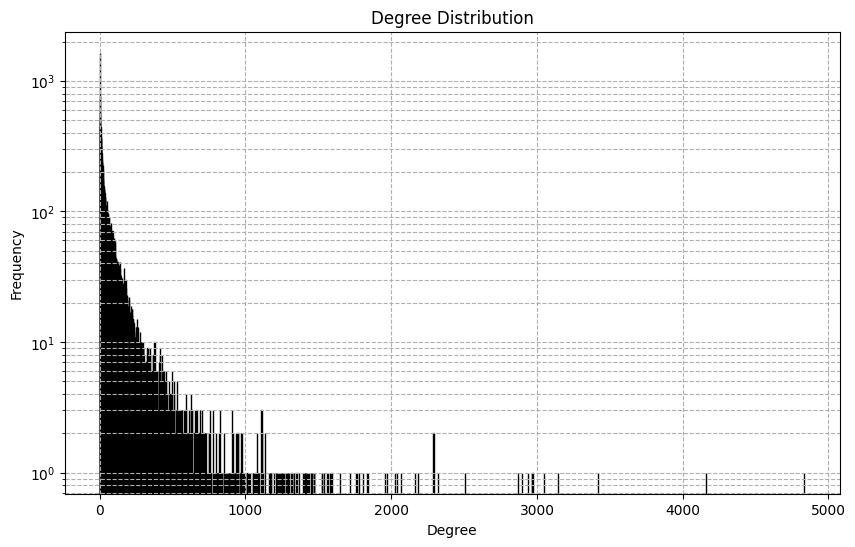

In [ ]:
# Plot degree distribution
plt.figure(figsize=(10, 6))
plt.bar(degree_counts.index, degree_counts.values, width=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.yscale('log')  # Log scale for better visualization if degrees vary widely
plt.grid(True, which="both", ls="--")
plt.show()

---

Based on this degree distribution, I would describe this as a **scale-free network** with the following characteristics:

**Power-law distribution**: The plot shows a clear power-law decay on the log-scale y-axis, where frequency decreases dramatically as degree increases. This is the hallmark of a scale-free network, following approximately f(k) ∝ k^(-γ) where γ is typically between 2-3.

**Heavy-tailed distribution**: Unlike random networks (which have Poisson degree distributions), this network has a "heavy tail" - while most nodes have very low degrees (1-10 connections), there are still nodes with extremely high degrees (hundreds to thousands of connections).

**Hub structure**: The network contains a small number of highly connected "hub" nodes (degree > 100) alongside many nodes with just a few connections. These hubs play a critical role in network connectivity and information flow.

**Real-world characteristics**: This type of distribution is typical of many real networks including:
- Social networks (most people have few connections, celebrities have many)
- Web graphs (most pages have few links, popular sites have many)
- Biological networks (protein interaction, metabolic networks)
- Citation networks

**Network properties**: Such networks typically exhibit:
- High clustering around hubs
- Small average path lengths ("small world" effect)
- Robustness to random failures but vulnerability to targeted hub attacks
- Efficient information spreading through hubs

The sharp cutoff around degree 1000+ might indicate structural constraints or finite-size effects in the network.

EXAMPLE 2: How to use with your network data
----------------------------------------
SCALE-FREE NETWORK ANALYSIS
Network size: 20045 nodes
Degree range: 1 - 4834
Mean degree: 86.97
Degree std: 167.91

POWER-LAW FIT (MLE):
  Scaling exponent (α): 1.689 ± 0.006
  Lower bound (xmin): 20
  Nodes in tail: 12325 (61.5%)

Testing power-law hypothesis...
  Bootstrap p-value: 0.000
  → Power-law is rejected (p < 0.05)

COMPARISON WITH ALTERNATIVE DISTRIBUTIONS:
  vs Lognormal:
    Likelihood ratio: -84622.08
    Better fit: lognormal
  vs Exponential:
    Likelihood ratio: -80895.31
    Better fit: exponential

ASSESSMENT:
✗ Network does NOT appear to be scale-free
  - Scaling exponent outside typical range: 1.689
  - Statistical test rejects power-law: p = 0.000


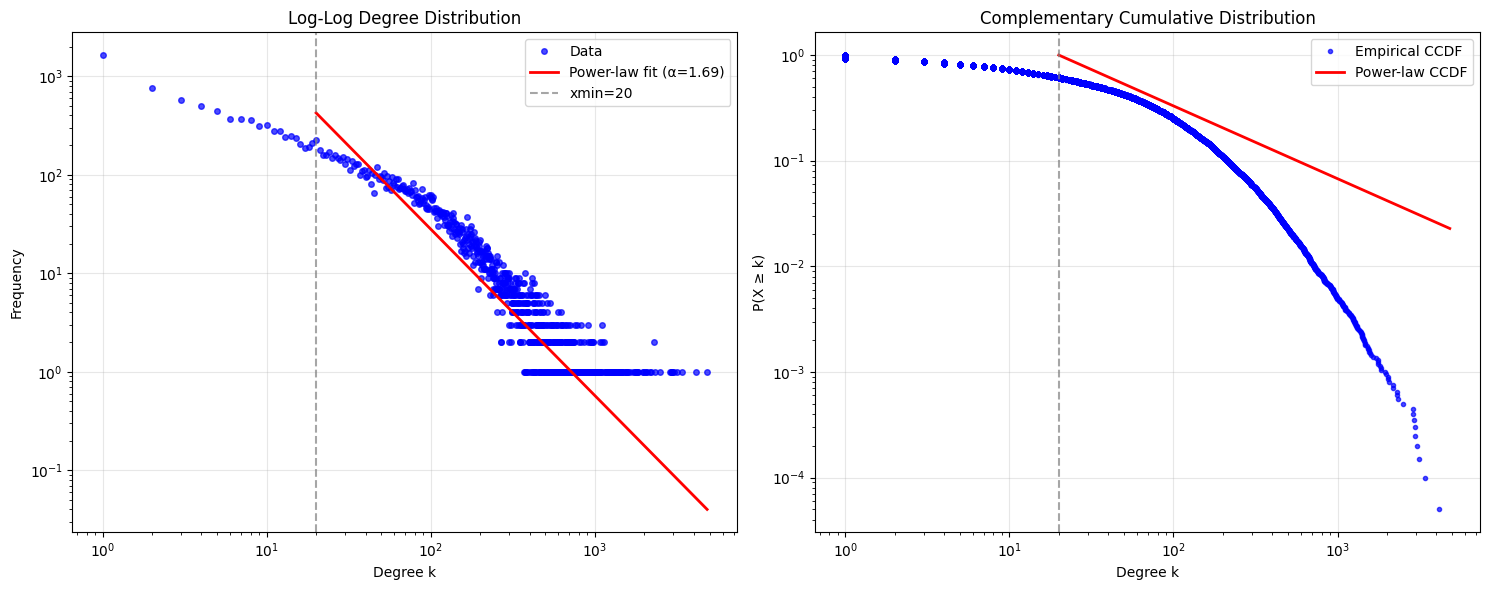

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class ScaleFreeAnalyzer:
    def __init__(self, degrees):
        """
        Initialize with degree sequence
        degrees: list or array of node degrees
        """
        self.degrees = np.array(degrees)
        self.degree_counts = Counter(self.degrees)
        self.unique_degrees = np.array(sorted(self.degree_counts.keys()))
        self.frequencies = np.array([self.degree_counts[k] for k in self.unique_degrees])

    def fit_power_law_mle(self, xmin=None):
        """
        Fit power-law using Maximum Likelihood Estimation
        Returns: alpha (scaling exponent), xmin (lower bound), sigma (uncertainty)
        """
        if xmin is None:
            # Find optimal xmin using KS statistic
            xmin = self._find_optimal_xmin()

        # Filter data >= xmin
        data = self.degrees[self.degrees >= xmin]
        n = len(data)

        if n < 50:
            print(f"Warning: Only {n} data points >= xmin={xmin}")

        # MLE estimate: alpha = 1 + n / sum(ln(xi/xmin))
        alpha = 1 + n / np.sum(np.log(data / xmin))

        # Standard error
        sigma = (alpha - 1) / np.sqrt(n)

        return alpha, xmin, sigma

    def _find_optimal_xmin(self):
        """Find xmin that minimizes KS distance"""
        possible_xmins = self.unique_degrees[self.unique_degrees >= 1]
        best_xmin = 1
        best_ks = float('inf')

        for xmin in possible_xmins[:20]:  # Test first 20 values for efficiency
            try:
                alpha, _, _ = self.fit_power_law_mle(xmin)
                ks_stat = self._ks_distance(alpha, xmin)
                if ks_stat < best_ks:
                    best_ks = ks_stat
                    best_xmin = xmin
            except:
                continue

        return best_xmin

    def _ks_distance(self, alpha, xmin):
        """Kolmogorov-Smirnov distance between data and power-law"""
        data = self.degrees[self.degrees >= xmin]
        n = len(data)

        # Empirical CDF
        sorted_data = np.sort(data)
        empirical_cdf = np.arange(1, n + 1) / n

        # Theoretical power-law CDF: 1 - (x/xmin)^(1-alpha)
        theoretical_cdf = 1 - (sorted_data / xmin) ** (1 - alpha)

        # KS statistic
        ks_stat = np.max(np.abs(empirical_cdf - theoretical_cdf))
        return ks_stat

    def bootstrap_power_law(self, alpha, xmin, n_bootstrap=1000):
        """
        Bootstrap test to get p-value for power-law hypothesis
        """
        data = self.degrees[self.degrees >= xmin]
        n = len(data)
        original_ks = self._ks_distance(alpha, xmin)

        # Generate synthetic power-law data and compute KS statistics
        synthetic_ks = []
        for _ in range(n_bootstrap):
            # Generate power-law distributed random numbers
            u = np.random.uniform(0, 1, n)
            synthetic = xmin * (1 - u) ** (-1 / (alpha - 1))

            # Fit power-law to synthetic data
            try:
                alpha_syn = 1 + n / np.sum(np.log(synthetic / xmin))
                ks_syn = self._ks_distance_synthetic(synthetic, alpha_syn, xmin)
                synthetic_ks.append(ks_syn)
            except:
                continue

        # P-value: fraction of synthetic KS stats >= observed KS stat
        p_value = np.mean(np.array(synthetic_ks) >= original_ks)
        return p_value

    def _ks_distance_synthetic(self, synthetic_data, alpha, xmin):
        """KS distance for synthetic data"""
        n = len(synthetic_data)
        sorted_data = np.sort(synthetic_data)
        empirical_cdf = np.arange(1, n + 1) / n
        theoretical_cdf = 1 - (sorted_data / xmin) ** (1 - alpha)
        return np.max(np.abs(empirical_cdf - theoretical_cdf))

    def fit_alternative_distributions(self, xmin):
        """Fit alternative heavy-tailed distributions"""
        data = self.degrees[self.degrees >= xmin]

        results = {}

        # Log-normal
        try:
            log_data = np.log(data)
            mu, sigma = np.mean(log_data), np.std(log_data)
            ll_lognormal = np.sum(stats.lognorm.logpdf(data, sigma, scale=np.exp(mu)))
            results['lognormal'] = {'mu': mu, 'sigma': sigma, 'loglikelihood': ll_lognormal}
        except:
            results['lognormal'] = None

        # Exponential
        try:
            rate = 1 / np.mean(data)
            ll_exponential = np.sum(stats.expon.logpdf(data, scale=1/rate))
            results['exponential'] = {'rate': rate, 'loglikelihood': ll_exponential}
        except:
            results['exponential'] = None

        return results

    def likelihood_ratio_test(self, alpha, xmin):
        """Compare power-law to alternative distributions using likelihood ratio"""
        data = self.degrees[self.degrees >= xmin]
        n = len(data)

        # Power-law log-likelihood
        ll_powerlaw = -n * np.log(alpha - 1) - n * (alpha - 1) * np.log(xmin) - alpha * np.sum(np.log(data))

        # Alternative distributions
        alternatives = self.fit_alternative_distributions(xmin)

        results = {}
        for dist_name, params in alternatives.items():
            if params is not None:
                ll_alt = params['loglikelihood']
                lr = 2 * (ll_powerlaw - ll_alt)  # Likelihood ratio statistic
                # For nested models, LR ~ chi-square, but these aren't nested
                # So we'll just report the raw LR and log-likelihoods
                results[dist_name] = {
                    'likelihood_ratio': lr,
                    'll_powerlaw': ll_powerlaw,
                    'll_alternative': ll_alt,
                    'better_fit': 'power-law' if lr > 0 else dist_name
                }

        return results

    def analyze_scale_free(self, plot=True, verbose=True):
        """
        Complete scale-free analysis
        """
        print("="*60)
        print("SCALE-FREE NETWORK ANALYSIS")
        print("="*60)

        # Basic statistics
        print(f"Network size: {len(self.degrees)} nodes")
        print(f"Degree range: {min(self.degrees)} - {max(self.degrees)}")
        print(f"Mean degree: {np.mean(self.degrees):.2f}")
        print(f"Degree std: {np.std(self.degrees):.2f}")
        print()

        # Fit power-law
        alpha, xmin, sigma = self.fit_power_law_mle()
        print(f"POWER-LAW FIT (MLE):")
        print(f"  Scaling exponent (α): {alpha:.3f} ± {sigma:.3f}")
        print(f"  Lower bound (xmin): {xmin}")
        print(f"  Nodes in tail: {np.sum(self.degrees >= xmin)} ({100*np.sum(self.degrees >= xmin)/len(self.degrees):.1f}%)")
        print()

        # Bootstrap p-value
        print("Testing power-law hypothesis...")
        p_value = self.bootstrap_power_law(alpha, xmin, n_bootstrap=500)
        print(f"  Bootstrap p-value: {p_value:.3f}")

        # Interpretation
        if p_value >= 0.1:
            print("  → Power-law is plausible (p ≥ 0.1)")
        elif p_value >= 0.05:
            print("  → Power-law is marginally plausible (0.05 ≤ p < 0.1)")
        else:
            print("  → Power-law is rejected (p < 0.05)")
        print()

        # Compare to alternatives
        print("COMPARISON WITH ALTERNATIVE DISTRIBUTIONS:")
        lr_results = self.likelihood_ratio_test(alpha, xmin)
        for dist_name, result in lr_results.items():
            print(f"  vs {dist_name.capitalize()}:")
            print(f"    Likelihood ratio: {result['likelihood_ratio']:.2f}")
            print(f"    Better fit: {result['better_fit']}")
        print()

        # Final assessment
        print("ASSESSMENT:")
        is_scale_free = (p_value >= 0.05 and
                        2.0 <= alpha <= 3.5 and  # Typical range for real networks
                        np.sum(self.degrees >= xmin) >= 50)  # Sufficient tail data

        if is_scale_free:
            print("✓ Network appears to be SCALE-FREE")
            print(f"  - Power-law exponent in realistic range: {alpha:.3f}")
            print(f"  - Statistical test supports power-law: p = {p_value:.3f}")
        else:
            print("✗ Network does NOT appear to be scale-free")
            if alpha < 2.0 or alpha > 3.5:
                print(f"  - Scaling exponent outside typical range: {alpha:.3f}")
            if p_value < 0.05:
                print(f"  - Statistical test rejects power-law: p = {p_value:.3f}")
            if np.sum(self.degrees >= xmin) < 50:
                print(f"  - Insufficient data in power-law regime: {np.sum(self.degrees >= xmin)} nodes")

        print("="*60)

        if plot:
            self.plot_analysis(alpha, xmin)

        return {
            'is_scale_free': is_scale_free,
            'alpha': alpha,
            'xmin': xmin,
            'p_value': p_value,
            'sigma': sigma
        }

    def plot_analysis(self, alpha, xmin):
        """Plot degree distribution with power-law fit"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Log-log plot
        ax1.loglog(self.unique_degrees, self.frequencies, 'bo', alpha=0.7, markersize=4, label='Data')

        # Power-law fit line
        x_fit = np.linspace(xmin, max(self.unique_degrees), 100)
        # P(k) ∝ k^(-α), normalized
        C = (alpha - 1) * xmin**(alpha - 1)
        y_fit = C * x_fit**(-alpha)
        # Scale to match frequency (not probability)
        y_fit = y_fit * np.sum(self.degrees >= xmin)

        ax1.loglog(x_fit, y_fit, 'r-', linewidth=2, label=f'Power-law fit (α={alpha:.2f})')
        ax1.axvline(xmin, color='gray', linestyle='--', alpha=0.7, label=f'xmin={xmin}')

        ax1.set_xlabel('Degree k')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Log-Log Degree Distribution')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # CDF plot
        degrees_sorted = np.sort(self.degrees)
        ccdf = 1 - np.arange(1, len(degrees_sorted) + 1) / len(degrees_sorted)

        ax2.loglog(degrees_sorted, ccdf, 'bo', alpha=0.7, markersize=3, label='Empirical CCDF')

        # Theoretical CCDF for power-law
        tail_data = degrees_sorted[degrees_sorted >= xmin]
        ccdf_theory = (tail_data / xmin) ** (-(alpha - 1))
        ax2.loglog(tail_data, ccdf_theory, 'r-', linewidth=2, label='Power-law CCDF')
        ax2.axvline(xmin, color='gray', linestyle='--', alpha=0.7)

        ax2.set_xlabel('Degree k')
        ax2.set_ylabel('P(X ≥ k)')
        ax2.set_title('Complementary Cumulative Distribution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Example usage:
if __name__ == "__main__":
    print("EXAMPLE 2: How to use with your network data")
    print("-" * 40)



import networkx as nx
degrees = [G.degree(node) for node in G.nodes()]
analyzer = ScaleFreeAnalyzer(degrees)
result = analyzer.analyze_scale_free()


---

In [ ]:
# 3. Additional Interesting Metrics
# Clustering Coefficient
avg_clustering = nx.average_clustering(G)
print("\n=== Clustering Coefficient ===")
print(f"Average clustering coefficient: {avg_clustering:.4f}")


=== Clustering Coefficient ===
Average clustering coefficient: 0.1374


In [ ]:
!pip install python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.3 MB/s eta 0:00:00


In [ ]:
import igraph as ig


# Assuming unique_interactions is your DataFrame
# Create NetworkX graph
#G = nx.from_pandas_edgelist(unique_interactions, "Official Symbol Interactor A", "Official Symbol Interactor B")

# Get all unique nodes from the graph
nodes = list(G.nodes())

# Create a mapping of node names to integer IDs (0 to n-1)
node_to_id = {node: idx for idx, node in enumerate(nodes)}

# Convert edges to use integer IDs
edges = [(node_to_id[u], node_to_id[v]) for u, v in G.edges()]

# Create iGraph graph
ig_graph = ig.Graph(edges=edges, directed=False)

# Optionally, store the original node names as vertex attributes
ig_graph.vs["name"] = nodes

# Compute diameter
diameter = ig_graph.diameter()
print(f"Diameter: {diameter}")

Diameter: 7


In [ ]:
degree = dict(G.degree)

In [ ]:
# Compute betweenness centrality
betweenness = ig_graph.betweenness(vertices=None, directed=False, cutoff=None)

# Map results back to original node names
betweenness_dict = {nodes[i]: betweenness[i] for i in range(len(nodes))}

# Print or use the results
print("Betweenness Centrality:", betweenness_dict)

Betweenness Centrality: {'MAP2K4': 4982.75721612566, 'FLNC': 41958.81096380812, 'MYPN': 920.0819100055918, 'ACTN2': 22712.64392565385, 'ACVR1': 6775.9270613282915, 'FNTA': 6656.71448535341, 'GATA2': 11800.039841222759, 'PML': 268746.7644764279, 'RPA2': 1429208.8201113953, 'STAT3': 135196.55174718442, 'ARF1': 15323.536132334057, 'GGA3': 11345.258479648588, 'ARF3': 5348.036672254155, 'ARFIP2': 11746.784603624475, 'ARFIP1': 10502.813032147089, 'XRN1': 74468.28985797476, 'ALDOA': 59503.38116114496, 'APP': 5712927.589077661, 'APPBP2': 79835.59127513718, 'APLP1': 2798.8539738585537, 'DAB1': 7202.339107994798, 'CITED2': 169.72840612414268, 'TFAP2A': 5516.5830875100355, 'EP300': 631834.9164713171, 'APOB': 47783.405231526165, 'MTTP': 75.81255925404871, 'ARRB2': 131624.7142725083, 'RALGDS': 2049.8565017657997, 'CSF1R': 1004.0779228954847, 'GRB2': 423176.00740484946, 'PRRC2A': 47188.296954776095, 'LSM1': 8850.527599512907, 'NARS': 16379.764971296105, 'SLC4A1': 529.7718276948083, 'SLC4A1AP': 7106.

In [ ]:
# Compute eigenvector centrality
eigenvector_centrality = ig_graph.eigenvector_centrality(directed=False, weights=None)

# Map eigenvector centrality results to original node names
eigenvector_dict = {nodes[i]: eigenvector_centrality[i] for i in range(len(nodes))}

In [ ]:
# Compute closeness centrality
closeness_centrality = ig_graph.closeness(vertices=None, mode='all', cutoff=None, weights=None, normalized=True)

# Map closeness centrality results to original node names
closeness_dict = {nodes[i]: closeness_centrality[i] for i in range(len(nodes))}

In [ ]:
print("Eigenvector Centrality:", eigenvector_dict)
print("Closeness Centrality:", closeness_dict)

Eigenvector Centrality: {'MAP2K4': 0.026081662151665037, 'FLNC': 0.0913423205984648, 'MYPN': 0.011690386454266382, 'ACTN2': 0.032739187008758316, 'ACVR1': 0.010901385060324708, 'FNTA': 0.02536252124190349, 'GATA2': 0.047309536168075254, 'PML': 0.2818182688487157, 'RPA2': 0.7926709833418015, 'STAT3': 0.12458006445336355, 'ARF1': 0.08406688179077887, 'GGA3': 0.033684232112885376, 'ARF3': 0.060383658346775664, 'ARFIP2': 0.024071057571088548, 'ARFIP1': 0.04405245851894295, 'XRN1': 0.10410578875706726, 'ALDOA': 0.14875951183721936, 'APP': 0.32923552878545687, 'APPBP2': 0.02144433018066918, 'APLP1': 0.010270053971509952, 'DAB1': 0.016549335103750867, 'CITED2': 0.005515642739603732, 'TFAP2A': 0.04128072868886428, 'EP300': 0.3913490379190314, 'APOB': 0.045282660446214804, 'MTTP': 0.008289634958200332, 'ARRB2': 0.1715241471331325, 'RALGDS': 0.007986032164866185, 'CSF1R': 0.012819233958918205, 'GRB2': 0.18807696660717438, 'PRRC2A': 0.1669038471510081, 'LSM1': 0.031230245650163205, 'NARS': 0.0736

In [ ]:
# We create a dataframe with these metrics
metrics_df = pd.DataFrame({
    "Gene": list(nodes),
    "Degree": [degree[node] for node in nodes],
    "Betweenness": [betweenness_dict[node] for node in nodes],
    "Eigenvector": [eigenvector_dict[node] for node in nodes],
    "Closeness": [closeness_dict[node] for node in nodes]
})
metrics_df["Betweenness/Degree"] = metrics_df["Betweenness"] / metrics_df["Degree"]

# We sort by degree
metrics_df = metrics_df.sort_values(by="Degree", ascending=False)

In [ ]:
print(metrics_df.head(10))

           Gene  Degree   Betweenness  Eigenvector  Closeness  \
17358    TRIM67    4834  7.929504e+06     1.000000   0.554299   
7310     ZRANB1    4160  5.409380e+06     0.918019   0.537387   
2038      PARK2    3416  5.047168e+06     0.794409   0.529340   
1064       CUL3    3146  5.721005e+06     0.710737   0.523274   
67         RPA1    3049  1.672817e+06     0.840127   0.522619   
5454    PLEKHA4    2969  2.204821e+06     0.746107   0.517358   
2533        MYC    2964  2.203493e+06     0.803328   0.518469   
8766   KIAA1429    2936  5.772632e+06     0.600235   0.514081   
8          RPA2    2897  1.429209e+06     0.792671   0.517184   
68         RPA3    2872  1.325743e+06     0.782048   0.516452   

       Betweenness/Degree  
17358         1640.360764  
7310          1300.331824  
2038          1477.508174  
1064          1818.501190  
67             548.644533  
5454           742.614142  
2533           743.418800  
8766          1966.155348  
8              493.340980  
68  

In [ ]:
# Detect communities using Louvain algorithm (fast and effective)
communities = ig_graph.community_multilevel()  # Louvain method

# Compute modularity
modularity = ig_graph.modularity(communities, weights=None)

# Map community assignments to original node names
community_dict = {nodes[i]: communities.membership[i] for i in range(len(nodes))}


In [ ]:
# Print results
print(f"Modularity: {modularity}")
print(f"Number of clusters: {len(communities)}")
print("Community assignments:", community_dict)

Modularity: 0.3018022818380612
Number of clusters: 8
Community assignments: {'MAP2K4': 0, 'FLNC': 1, 'MYPN': 1, 'ACTN2': 1, 'ACVR1': 2, 'FNTA': 1, 'GATA2': 3, 'PML': 3, 'RPA2': 4, 'STAT3': 3, 'ARF1': 2, 'GGA3': 2, 'ARF3': 2, 'ARFIP2': 2, 'ARFIP1': 2, 'XRN1': 1, 'ALDOA': 0, 'APP': 0, 'APPBP2': 0, 'APLP1': 0, 'DAB1': 5, 'CITED2': 3, 'TFAP2A': 3, 'EP300': 3, 'APOB': 2, 'MTTP': 2, 'ARRB2': 4, 'RALGDS': 1, 'CSF1R': 2, 'GRB2': 0, 'PRRC2A': 4, 'LSM1': 4, 'NARS': 4, 'SLC4A1': 2, 'SLC4A1AP': 4, 'BCL3': 3, 'BARD1': 4, 'ADRB1': 1, 'GIPC1': 1, 'BRCA1': 4, 'ATF1': 3, 'MSH2': 4, 'MSH6': 4, 'ARVCF': 2, 'CDH15': 2, 'PCBD1': 3, 'CACNA1C': 3, 'PSEN2': 0, 'CAPN1': 0, 'CAPN3': 5, 'TTN': 4, 'ITPR1': 2, 'CA8': 0, 'MAGI1': 1, 'CTNNB1': 3, 'RB1': 3, 'CUX1': 3, 'TSG101': 1, 'CDKN1A': 0, 'ORC1': 4, 'MCM2': 4, 'ORC4': 2, 'MCM5': 4, 'CDC7': 5, 'ORC2': 4, 'DBF4': 4, 'AKAP8': 4, 'RPA1': 4, 'RPA3': 4, 'ORC5': 2, 'MCM3': 4, 'YWHAZ': 1, 'CDC25A': 0, 'DOCK8': 0, 'CDC42': 2, 'TRIP10': 1, 'CDKN3': 0, 'CDK2': 4, 'RBBP8': 

In [ ]:
cluster_sizes = communities.sizes()
print("Cluster sizes:", cluster_sizes)

Cluster sizes: [3743, 3478, 4937, 1684, 2922, 2266, 978, 37]


#### ANALISI CLUSTER

In [ ]:
import networkx as nx
import igraph as ig
import pandas as pd
from collections import defaultdict



# Detect communities using Louvain algorithm
communities = ig_graph.community_multilevel()

In [ ]:
# Initialize results
cluster_analysis = defaultdict(list)
high_degree_threshold = 40

# Analyze each cluster
for cluster_id in range(len(communities)):
    # Get nodes in the current cluster
    cluster_nodes = [i for i, membership in enumerate(communities.membership) if membership == cluster_id]

    # Create subgraph for the cluster
    subgraph = ig_graph.subgraph(cluster_nodes)

    # Compute intra-cluster degrees
    intra_degrees = subgraph.degree()

    # Map degrees to original node names
    cluster_node_names = [nodes[i] for i in cluster_nodes]
    degree_dict = {cluster_node_names[i]: intra_degrees[i] for i in range(len(cluster_nodes))}

    # Identify high-degree nodes (degree >= threshold)
    high_degree_nodes = {node: deg for node, deg in degree_dict.items() if deg >= high_degree_threshold}

    # Store cluster info
    cluster_analysis[cluster_id] = {
        'size': len(cluster_nodes),
        'avg_degree': sum(intra_degrees) / len(cluster_nodes) if cluster_nodes else 0,
        'high_degree_nodes': high_degree_nodes,
        'num_high_degree_nodes': len(high_degree_nodes)
    }

# Print analysis
print(f"Total number of clusters: {len(communities)}")
for cluster_id, info in cluster_analysis.items():
    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {info['size']} nodes")
    print(f"  Average intra-cluster degree: {info['avg_degree']:.2f}")
    print(f"  Number of high-degree nodes (degree >= {high_degree_threshold}): {info['num_high_degree_nodes']}")
    print(f"  High-degree nodes: {info['high_degree_nodes']}")

# Identify clusters with high connectivity (e.g., high average degree or many high-degree nodes)
high_connectivity_clusters = [
    (cid, info) for cid, info in cluster_analysis.items()
    if info['avg_degree'] > 2 or info['num_high_degree_nodes'] > 0  # Adjust criteria
]
print("\nClusters with high connectivity:")
for cid, info in high_connectivity_clusters:
    print(f"Cluster {cid}: Size={info['size']}, Avg Degree={info['avg_degree']:.2f}, "
          f"High-degree nodes={info['num_high_degree_nodes']}")

Total number of clusters: 8

Cluster 0:
  Size: 5410 nodes
  Average intra-cluster degree: 42.68
  Number of high-degree nodes (degree >= 40): 1704
  High-degree nodes: {'FLNC': 119, 'ACTN2': 61, 'ALDOA': 123, 'APPBP2': 76, 'ARRB2': 166, 'GRB2': 351, 'GIPC1': 42, 'CAPN1': 80, 'TTN': 111, 'MAGI1': 94, 'CTNNB1': 360, 'TSG101': 113, 'CDKN1A': 156, 'YWHAZ': 661, 'CDC25A': 60, 'DOCK8': 43, 'TRIP10': 41, 'CDK2': 311, 'CLTC': 296, 'TXN': 131, 'RALBP1': 73, 'CCNB1': 113, 'PPIB': 116, 'CSK': 76, 'PCNA': 190, 'GADD45A': 41, 'FLNA': 300, 'EPB41': 48, 'PLCG1': 119, 'EEF1D': 132, 'KDR': 54, 'ANXA5': 88, 'FDPS': 55, 'FAS': 132, 'FTL': 134, 'GABARAP': 73, 'SFN': 379, 'ECD': 65, 'P4HA2': 63, 'PSMA3': 195, 'BAG6': 175, 'HTT': 164, 'YWHAQ': 610, 'IRS1': 62, 'YWHAE': 641, 'SOCS1': 93, 'PTK2': 141, 'MAPK8': 116, 'JAK2': 61, 'KRT8': 240, 'KRT18': 205, 'CBL': 252, 'DNAJB6': 150, 'BCR': 106, 'BCL2': 59, 'TP53BP2': 128, 'BECN1': 117, 'SKAP1': 46, 'VAV1': 81, 'MAP1B': 209, 'PFN1': 251, 'NEB': 45, 'PRKACB': 88,


####
---



---



---

In [ ]:
np.percentile(metrics_df["Degree"],99),np.percentile(metrics_df["Betweenness"],99)

(np.float64(332.0), np.float64(51877.03765920414))

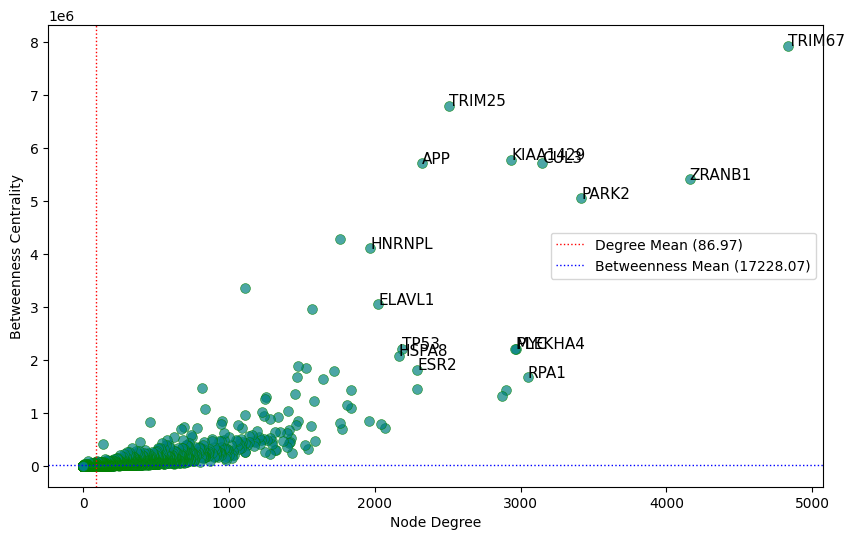

In [ ]:
degree_mean = metrics_df["Degree"].mean()
betweenness_mean = metrics_df["Betweenness"].mean()

thresh_mean = np.percentile(metrics_df["Degree"],99.9)
thresh_betw = np.percentile(metrics_df["Betweenness"],99.9)

plt.figure(figsize=(10, 6))
plt.scatter(metrics_df["Degree"], metrics_df["Betweenness"], alpha=0.7,
            c='teal', s=50, edgecolors='g', linewidth=0.5)


for i, row in metrics_df.iterrows():
    if row["Degree"] > thresh_mean and row["Betweenness"] > thresh_betw:
        plt.text(row["Degree"], row["Betweenness"], row["Gene"],
                 fontsize=11)



plt.axvline(degree_mean, color='red', linestyle=':', linewidth=1, label=f'Degree Mean ({degree_mean:.2f})')
plt.axhline(betweenness_mean, color='blue', linestyle=':', linewidth=1, label=f'Betweenness Mean ({betweenness_mean:.2f})')

plt.xlabel("Node Degree")
plt.ylabel("Betweenness Centrality")
plt.legend()
plt.show()

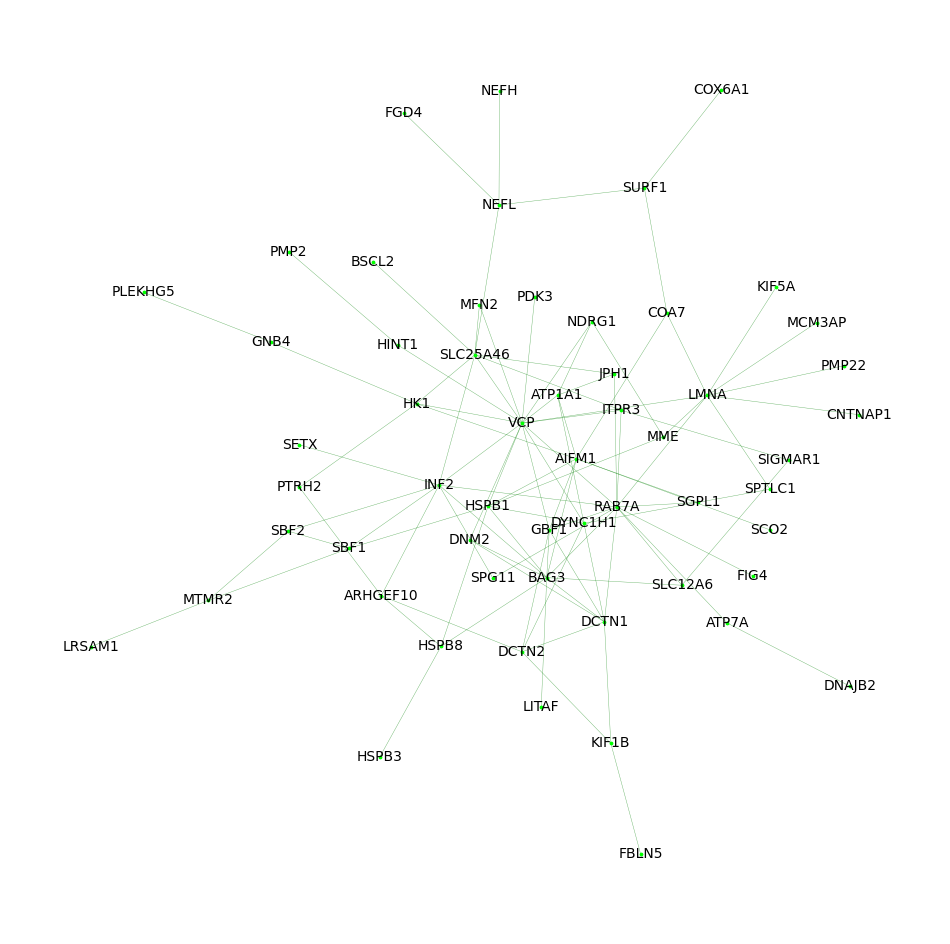

In [ ]:
final_graph = nx.Graph()
final_graph.add_nodes_from(disease_lcc_subgraph.nodes(data=True))
final_graph.add_edges_from(disease_lcc_subgraph.edges(data=True))


plt.figure(figsize=(12, 12))
#pos = nx.spring_layout(final_graph, seed=214)
pos= nx.kamada_kawai_layout(final_graph, weight=None)  # or use nx.kamada_kawai_layout for better spacing
nx.draw_networkx_nodes(final_graph, pos,node_color='lime',node_size=3, alpha=1)
nx.draw_networkx_edges(final_graph, pos,edge_color='green', width=0.3, alpha=0.6)
nx.draw_networkx_labels(final_graph, pos,labels={node: node for node in final_graph.nodes()},font_size=10,font_color='black')

# plt.title("Disease LCC")
plt.axis('off')
plt.show()


# PUNTO 2!

## PUNTO 2.1

### DIAMOND

### Diffusion-based algorithm

In [ ]:
# Define the Heat Diffusion methods.
import operator
import copy

from numpy import array
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import expm, expm_multiply

def diffuse(matrix, heat_array, time):
    return expm_multiply(-matrix, heat_array, start=0, stop=time, endpoint=True)[-1]

def sparse_laplacian(network, normalize=False):
    if normalize:
        return csc_matrix(nx.normalized_laplacian_matrix(network))
    else:
        return csc_matrix(nx.laplacian_matrix(network))

def create_heat_array(network, seed_genes, heat_value=1.0):
    heat_list = []
    for node in network.nodes:
        if node in seed_genes:
            heat_list.append(heat_value)
        else:
            heat_list.append(0.0)

    return array(heat_list)

def filter_node_list(node_list, nodes_to_remove):
    filtered_nodes = []
    for item in node_list:
        if item[0] not in nodes_to_remove:
            filtered_nodes.append(item[0])

    return filtered_nodes

def run_heat_diffusion(network, seed_genes, diffusion_time=0.005, n_positions=None):
    # Get the sparse Lapliacian matrix of the network.
    matrix = sparse_laplacian(network, normalize=True)

    # Create heat array.
    heat_array = create_heat_array(network, seed_genes)

    # Diffuse heat.
    diffused_heat_array = diffuse(matrix, heat_array, diffusion_time)

    # Get the heat of each node.
    node_heat = {node_name: diffused_heat_array[i] for i, node_name in enumerate(network.nodes())}

    # Sort the nodes by heat value.
    sorted_nodes = sorted(node_heat.items(), key=lambda x:x[1], reverse=True)

    # Remove from the sorted nodes the seed genes.
    predicted_genes = filter_node_list(sorted_nodes, seed_genes)

    if n_positions:
        # Return the top `n_positions` genes
        # wrt their heat value.
        return predicted_genes[:n_positions]

    return predicted_genes

In [ ]:
diffusion_times = [0.002, 0.005, 0.01]
results = {}

for t in diffusion_times:
    predicted_genes = run_heat_diffusion(
        network=G,
        seed_genes=seed_genes,
        diffusion_time=t,
        n_positions=200)
    results[t] =  predicted_genes


In [ ]:
print("t=0.002 results: ",*results[0.002][0:10])
print("t=0.005 results: ",*results[0.005][0:10])
print("t=0.01  results: ",*results[0.01][0:10])

t=0.002 results:  OR2A2 OTOL1 FGD3 BCYRN1 FAM178B SMLR1 FAM127B OLFML3 ANKRD7 KIAA1875
t=0.005 results:  OR2A2 OTOL1 FGD3 BCYRN1 FAM178B SMLR1 FAM127B OLFML3 ANKRD7 KIAA1875
t=0.01  results:  OR2A2 OTOL1 FGD3 BCYRN1 FAM178B SMLR1 FAM127B OLFML3 ANKRD7 KIAA1875


In [ ]:
set(results[0.002])-set(results[0.005]), set(results[0.005])-set(results[0.01]), set(results[0.002])-set(results[0.01])

(set(), set(), set())

In [ ]:
diable_genes = set(diable_results["DiaBLE_node"])
diamond_genes = set(diamond_results["DIAMOnD_node"])
heat_genes=set(results[0.01])

In [ ]:
print(f"genes present in all outputs: \n{list(heat_genes & diamond_genes & diable_genes)}")

genes present in all outputs: 
['VPS13D', 'EXD2', 'OCIAD1', 'MARCH5', 'MTCH1', 'FIS1', 'RHOT2', 'FKBP8', 'TDRKH', 'ALDH3A2', 'RAB3B']


In [ ]:
print(f"\nTotal genes in DiaBLE output: {len(diable_genes)}")
print(f"Total genes in DIAMOnD output: {len(diamond_genes)}")
print(f"Total genes in Heat output: {len(heat_genes)}")

print(f"\nNumber of genes common in DiaBLE and DIAMOnD: {len(diamond_genes & diable_genes)}")
print(f"Number of genes common in DiaBLE and Heat: {len(heat_genes & diable_genes)}")
print(f"Number of genes common in DIAMOnD and Heat: {len(diamond_genes & heat_genes)}")
print(f"Number of genes common in all three outputs: {len(diamond_genes & heat_genes & diable_genes)}")

print(f"\nNumber of genes unique to DIAMOnD: {len(diamond_genes - diable_genes - heat_genes)}")
print(f"Number of genes unique to DiaBLE: {len(diable_genes - diamond_genes - heat_genes)}")
print(f"Number of genes unique to Heat: {len(heat_genes - diamond_genes - diable_genes)}")


Total genes in DiaBLE output: 200
Total genes in DIAMOnD output: 200
Total genes in Heat output: 200

Number of genes common in DiaBLE and DIAMOnD: 37
Number of genes common in DiaBLE and Heat: 19
Number of genes common in DIAMOnD and Heat: 23
Number of genes common in all three outputs: 11

Number of genes unique to DIAMOnD: 151
Number of genes unique to DiaBLE: 155
Number of genes unique to Heat: 169


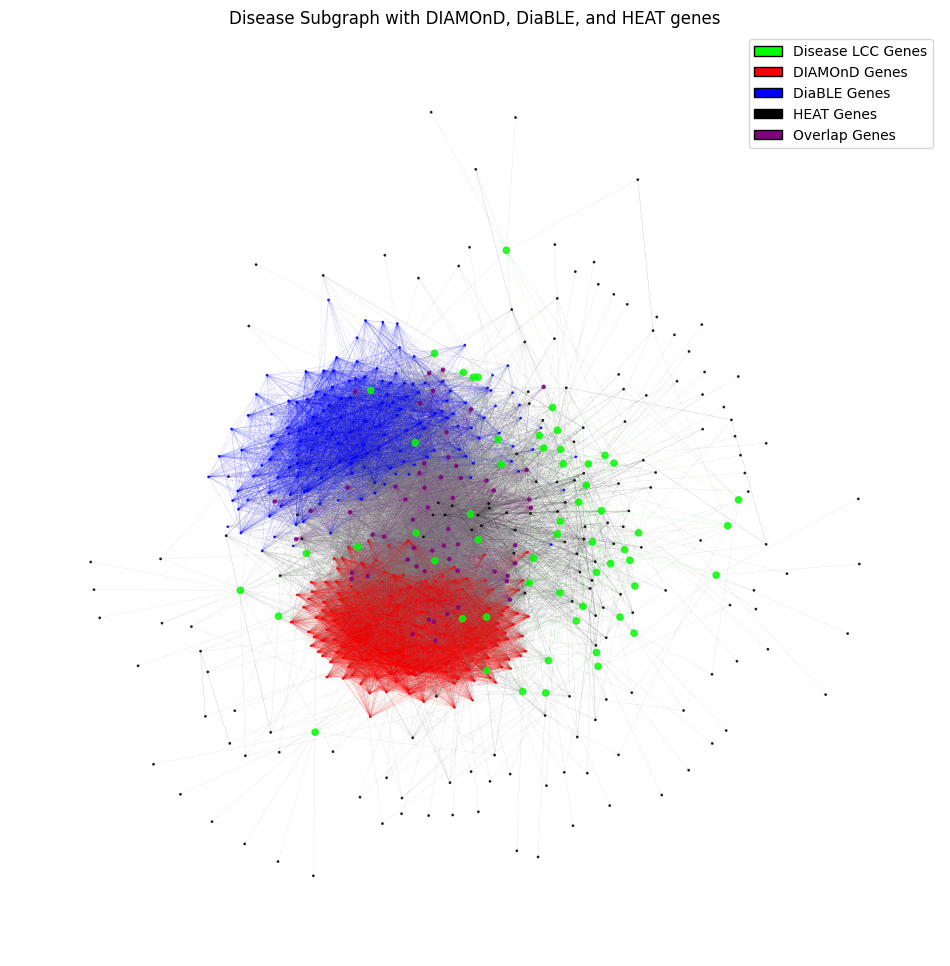

In [ ]:
final_graph = nx.Graph()
final_graph.add_nodes_from(disease_lcc_subgraph.nodes(data=True))
final_graph.add_edges_from(disease_lcc_subgraph.edges(data=True))

all_new_genes = diable_genes.union(diamond_genes).union(heat_genes)
for gene in all_new_genes:
    if gene in G:
        final_graph.add_node(gene)
        for neighbor in G.neighbors(gene):
            if neighbor in final_graph:
                final_graph.add_edge(gene, neighbor)


node_colors = {}
color_map = {
    'DIAMOnD': 'red',
    'DiaBLE': 'blue',
    'HEAT': 'black',
    'Overlap': 'purple',
    'Disease': 'lime',
}

node_sizes=[]
for node in final_graph.nodes():
    in_diable = node in diable_genes
    in_diamond = node in diamond_genes
    in_heat = node in heat_genes
    if in_diable + in_diamond + in_heat > 1:
        node_colors[node] = color_map['Overlap']
        node_sizes.append(5)
    elif in_diable:
        node_colors[node] = color_map['DiaBLE']
        node_sizes.append(1)
    elif in_diamond:
        node_colors[node] = color_map['DIAMOnD']
        node_sizes.append(1)
    elif in_heat:
        node_colors[node] = color_map['HEAT']
        node_sizes.append(1)
    else:
        node_colors[node] = color_map['Disease']
        node_sizes.append(20)


edge_colors = []
for u, v in final_graph.edges():
    if node_colors[u] == node_colors[v]:
        edge_colors.append(node_colors[u])
    else:
        edge_colors.append('grey')


plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(final_graph, weight=None)
nx.draw_networkx_nodes(final_graph, pos,node_color=[node_colors[node] for node in final_graph.nodes()],
                       node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(final_graph, pos,
                       edge_color=edge_colors, width=0.2, alpha=0.3)


legend_elements = [
    Patch(facecolor=color_map['Disease'], edgecolor='k', label='Disease LCC Genes'),
    Patch(facecolor=color_map['DIAMOnD'], edgecolor='k', label='DIAMOnD Genes'),
    Patch(facecolor=color_map['DiaBLE'], edgecolor='k', label='DiaBLE Genes'),
    Patch(facecolor=color_map['HEAT'], edgecolor='k', label='HEAT Genes'),
    Patch(facecolor=color_map['Overlap'], edgecolor='k', label='Overlap Genes'),
]
plt.legend(handles=legend_elements, loc='best', fontsize='medium')

plt.title("Disease Subgraph with DIAMOnD, DiaBLE, and HEAT genes")
plt.axis('off')
plt.show()


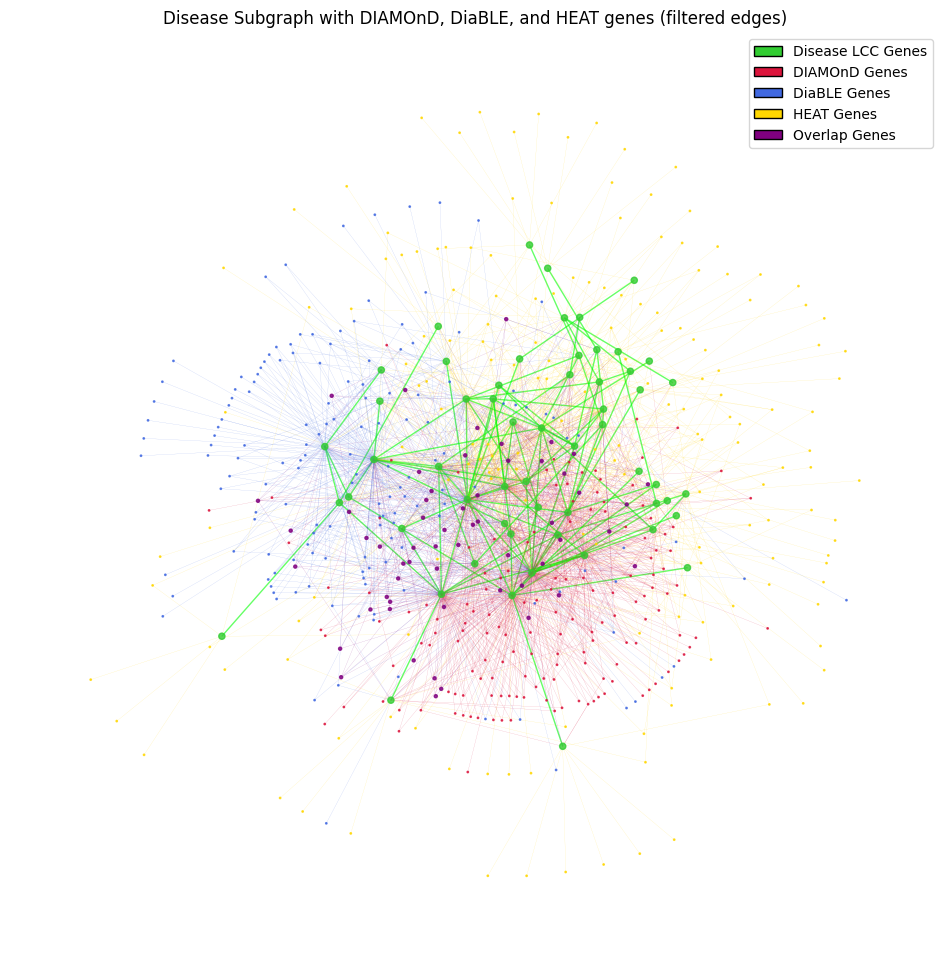

In [ ]:
final_graph = nx.Graph()
final_graph.add_nodes_from(disease_lcc_subgraph.nodes(data=True))
final_graph.add_edges_from(disease_lcc_subgraph.edges(data=True))

all_new_genes = diable_genes.union(diamond_genes).union(heat_genes)
for gene in all_new_genes:
    if gene in G:
        final_graph.add_node(gene)
        for neighbor in G.neighbors(gene):
            if neighbor in disease_lcc_subgraph:
                final_graph.add_edge(gene, neighbor)


node_colors = {}
color_map = {
    'DIAMOnD': '#DC143C',  # Crimson red
    'DiaBLE': '#4169E1',   # Royal blue
    'HEAT': '#FFD700',     # Gold
    'Overlap': '#800080',  # Purple
    'Disease': '#32CD32',  # Lime green
}


node_sizes=[]
for node in final_graph.nodes():
    in_diable = node in diable_genes
    in_diamond = node in diamond_genes
    in_heat = node in heat_genes
    if in_diable + in_diamond + in_heat > 1:
        node_colors[node] = color_map['Overlap']
        node_sizes.append(5)
    elif in_diable:
        node_colors[node] = color_map['DiaBLE']
        node_sizes.append(1)
    elif in_diamond:
        node_colors[node] = color_map['DIAMOnD']
        node_sizes.append(1)
    elif in_heat:
        node_colors[node] = color_map['HEAT']
        node_sizes.append(1)
    else:
        node_colors[node] = color_map['Disease']
        node_sizes.append(20)

edge_colors = []
edges_widthes = []
for u, v in final_graph.edges():
    u_in_disease = u in disease_lcc_subgraph
    v_in_disease = v in disease_lcc_subgraph

    if u_in_disease and v_in_disease:
        edge_colors.append('lime')
        edges_widthes.append(1)
    elif u_in_disease:
        edge_colors.append(node_colors[v])
        edges_widthes.append(0.1)
    elif v_in_disease:
        edge_colors.append(node_colors[u])
        edges_widthes.append(0.1)
    else:
        edge_colors.append('grey')
        edges_widthes.append(0.1)

plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(final_graph, weight=None)
nx.draw_networkx_nodes(final_graph, pos,node_color=[node_colors[node] for node in final_graph.nodes()],
                       node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(final_graph, pos, edge_color=edge_colors, width=edges_widthes, alpha=0.6)


legend_elements = [
    Patch(facecolor=color_map['Disease'], edgecolor='k', label='Disease LCC Genes'),
    Patch(facecolor=color_map['DIAMOnD'], edgecolor='k', label='DIAMOnD Genes'),
    Patch(facecolor=color_map['DiaBLE'], edgecolor='k', label='DiaBLE Genes'),
    Patch(facecolor=color_map['HEAT'], edgecolor='k', label='HEAT Genes'),
    Patch(facecolor=color_map['Overlap'], edgecolor='k', label='Overlap Genes'),
]
plt.legend(handles=legend_elements, loc='best', fontsize='medium')

plt.title("Disease Subgraph with DIAMOnD, DiaBLE, and HEAT genes (filtered edges)")
plt.axis('off')
plt.show()


## COMPUTATIONAL VALIDATION

In [ ]:
def compute_metrics(y_true, y_pred, top_k):

    top_predictions = set(y_pred[:top_k])  # Take top-k predictions
    true_positive = len(y_true.intersection(top_predictions))

    # Precision, Recall, F1-score
    precision = true_positive / top_k if top_k > 0 else 0
    recall = true_positive / len(y_true) if len(y_true) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

def sort_predictions_by_pvalue(predictions):

    # Check if predictions contain p-values
    if isinstance(predictions[0], tuple) and len(predictions[0]) == 2:
        sorted_predictions = sorted(predictions, key=lambda x: x[1])  # Sort by p-value
        return [gene for gene, _ in sorted_predictions]  # Return only genes
    else:
        return predictions  # Return as is if no p-values


def cross_validate(method, network, seed_genes, n_folds=5, diffusion_time=0.005, top_positions=None):

    # We initialize metrics
    results = {cutoff: {"precision": [], "recall": [], "f1": []} for cutoff in top_positions}

    # We split seed genes into n_folds
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=214214)
    fold_num = 1
    for train_idx, test_idx in kf.split(seed_genes):
        print(f"Fold {fold_num}:")

        S_T = [seed_genes[i] for i in train_idx]
        S_P = set(seed_genes[i] for i in test_idx)

        # We run the chosen method
        if method.__name__ == "run_heat_diffusion":
            predictions = method(network, S_T, diffusion_time=diffusion_time)
        else:
            predictions_with_pvalues = method(network, S_T)
            predictions = sort_predictions_by_pvalue(predictions_with_pvalues)

        # We remove training set (seed genes) from predictions
        predictions = [gene for gene in predictions if gene not in S_T]

        # We evaluate at each cutoff
        for cutoff in top_positions:
            precision, recall, f1 = compute_metrics(S_P, predictions, cutoff)
            results[cutoff]["precision"].append(precision)
            results[cutoff]["recall"].append(recall)
            results[cutoff]["f1"].append(f1)

           #print(f"Cutoff: {cutoff}, Precision: {precision}, Recall: {recall}, F1: {f1}")

        fold_num += 1

    # We calculate average and standard deviation for metrics
    final_results = {}
    for cutoff, metrics in results.items():
        final_results[cutoff] = {
            "precision_mean": np.mean(metrics["precision"]),
            "precision_std": np.std(metrics["precision"]),
            "recall_mean": np.mean(metrics["recall"]),
            "recall_std": np.std(metrics["recall"]),
            "f1_mean": np.mean(metrics["f1"]),
            "f1_std": np.std(metrics["f1"]),
        }

    return final_results

def run_DIAMOnD(graph, seeds, max_number_of_added_nodes=200, alpha=1):
    # We use a temporary file to store the output
    with tempfile.NamedTemporaryFile(delete=True) as temp_file:
        output_path = temp_file.name
        DIAMOnD.DIAMOnD(graph, seeds, max_number_of_added_nodes, alpha, outfile=output_path)
        # We load the results from the temporary file
        with open(output_path, "r") as f:
            next(f)
            results = [line.split("\t")[1] for line in f]  # We extract ranked genes
    return results

# we do the same for diable
def run_DiaBLE(graph, seeds, max_number_of_added_nodes=200, alpha=1):
  with tempfile.NamedTemporaryFile(delete=True) as temp_file:
        output_path = temp_file.name
        DiaBLE.DiaBLE(graph, seeds, max_number_of_added_nodes, alpha, outfile=output_path)
        with open(output_path, "r") as f:
            next(f)
            results = [line.split("\t")[1] for line in f]
  return results


In [ ]:
# we load the graph and seed genes
# G = nx.read_edgelist("/content/drive/My Drive/BIOINFORMATICS/network_file.tsv", delimiter="\t")
seed_genes=list(seed_genes)
# We define evaluation cutoffs
n = len(seed_genes)
top_positions = [50, n // 4, n // 2, n]
print(top_positions)

[50, 14, 28, 57]


In [ ]:
random.seed(214214)
np.random.seed(214214)

# We make cross-validations
diamond_results = cross_validate(run_DIAMOnD, network=G, seed_genes=seed_genes, top_positions=top_positions)
print("DIAMOnD Results:", diamond_results)

diable_results = cross_validate(run_DiaBLE, network=G, seed_genes=seed_genes, top_positions=top_positions)

print("DiaBLE Results:", diable_results)

diffusion_results = cross_validate(run_heat_diffusion, network=G, seed_genes=seed_genes, diffusion_time=0.005, top_positions=top_positions)

print("Heat Diffusion Results:", diffusion_results)

diffusion_results1 = cross_validate(run_heat_diffusion, network=G, seed_genes=seed_genes, diffusion_time=0.002, top_positions=top_positions)

print("Heat Diffusion Results:", diffusion_results1)

diffusion_results2 = cross_validate(run_heat_diffusion, network=G, seed_genes=seed_genes, diffusion_time=0.01, top_positions=top_positions)

print("Heat Diffusion Results:", diffusion_results2)


Fold 1:
Fold 2:
Fold 3:
Fold 4:
Fold 5:
DIAMOnD Results: {50: {'precision_mean': np.float64(0.016), 'precision_std': np.float64(0.014966629547095765), 'recall_mean': np.float64(0.06818181818181819), 'recall_std': np.float64(0.06283770107069006), 'f1_mean': np.float64(0.02591221575885775), 'f1_std': np.float64(0.02416890087734094)}, 14: {'precision_mean': np.float64(0.04285714285714286), 'precision_std': np.float64(0.034992710611188256), 'recall_mean': np.float64(0.051515151515151514), 'recall_std': np.float64(0.04215281134316229), 'f1_mean': np.float64(0.046769230769230764), 'f1_std': np.float64(0.03820344171118463)}, 28: {'precision_mean': np.float64(0.02142857142857143), 'precision_std': np.float64(0.017496355305594128), 'recall_mean': np.float64(0.051515151515151514), 'recall_std': np.float64(0.04215281134316229), 'f1_mean': np.float64(0.030256410256410255), 'f1_std': np.float64(0.02470869068030072)}, 57: {'precision_mean': np.float64(0.014035087719298244), 'precision_std': np.float

In [ ]:
import csv

def save_results_to_csv(results, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            "Top-K", "Precision Mean", "Precision Std",
            "Recall Mean", "Recall Std", "F1 Mean", "F1 Std"
        ])
        for cutoff, metrics in results.items():
            writer.writerow([
                cutoff,
                metrics["precision_mean"], metrics["precision_std"],
                metrics["recall_mean"], metrics["recall_std"],
                metrics["f1_mean"], metrics["f1_std"]
            ])

In [ ]:
save_results_to_csv(diamond_results, "/content/drive/My Drive/BIOINFORMATICS/diamond_results.csv")
save_results_to_csv(diable_results, "/content/drive/My Drive/BIOINFORMATICS/diable_results.csv")
save_results_to_csv(diffusion_results, "/content/drive/My Drive/BIOINFORMATICS/heat_diffusion_0.005.csv")
save_results_to_csv(diffusion_results1, "/content/drive/My Drive/BIOINFORMATICS/heat_diffusion_0.002.csv")
save_results_to_csv(diffusion_results2, "/content/drive/My Drive/BIOINFORMATICS/heat_diffusion_0.01.csv")

In [ ]:
def read_csv_to_dict(filename):
    results = {}
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            cutoff = int(row[0])
            results[cutoff] = {
                "precision_mean": float(row[1]),
                "precision_std": float(row[2]),
                "recall_mean": float(row[3]),
                "recall_std": float(row[4]),
                "f1_mean": float(row[5]),
                "f1_std": float(row[6])
            }
    return results



In [ ]:
# Read each CSV file
diamond_results_prova = read_csv_to_dict("/content/drive/My Drive/BIOINFORMATICS/diamond_results.csv")
diable_results_prova = read_csv_to_dict("/content/drive/My Drive/BIOINFORMATICS/diable_results.csv")
diffusion_results_prova = read_csv_to_dict("/content/drive/My Drive/BIOINFORMATICS/heat_diffusion_0.005.csv")


In [ ]:
diamond_results_prova[57], diable_results_prova[57], diffusion_results_prova[57]

({'precision_mean': 0.014035087719298244,
  'precision_std': 0.013128622409733127,
  'recall_mean': 0.06818181818181819,
  'recall_std': 0.06283770107069006,
  'f1_mean': 0.023273657289002558,
  'f1_std': 0.021714209341964497},
 {'precision_mean': 0.014035087719298244,
  'precision_std': 0.020459480332790526,
  'recall_mean': 0.06666666666666667,
  'recall_std': 0.09718253158075502,
  'f1_mean': 0.02318840579710145,
  'f1_std': 0.03380261968026261},
 {'precision_mean': 0.017543859649122806,
  'precision_std': 0.0,
  'recall_mean': 0.08787878787878789,
  'recall_std': 0.003711348095126031,
  'f1_mean': 0.029241261722080136,
  'f1_std': 0.0002088226549687275})

In [ ]:
cutoffs = [14, 28, 50, 57]

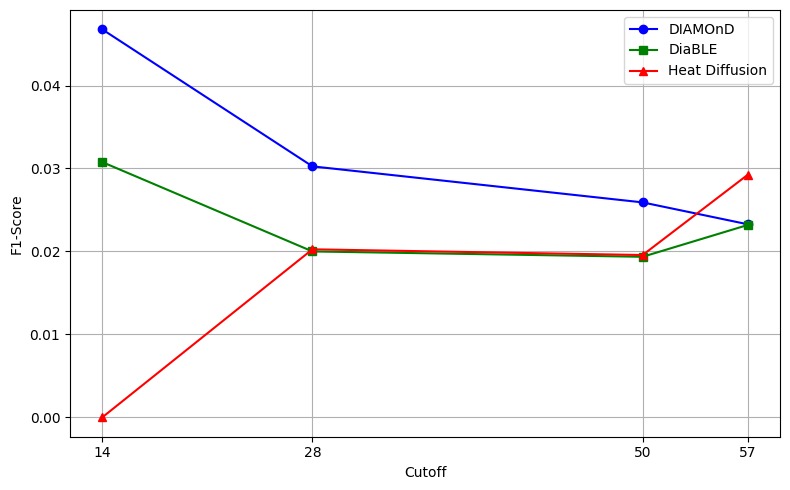

In [ ]:
# F1 scores for each method at each cutoff
diamond_f1 = [diamond_results[14]['f1_mean'],diamond_results[28]['f1_mean'],diamond_results[50]['f1_mean'],diamond_results[57]['f1_mean']]
diable_f1  = [diable_results[14]['f1_mean'],diable_results[28]['f1_mean'],diable_results[50]['f1_mean'],diable_results[57]['f1_mean']]
heat_f1    = [diffusion_results[14]['f1_mean'],diffusion_results[28]['f1_mean'],diffusion_results[50]['f1_mean'],diffusion_results[57]['f1_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(cutoffs, diamond_f1, marker='o', label='DIAMOnD', color='blue')
plt.plot(cutoffs, diable_f1, marker='s', label='DiaBLE', color='green')
plt.plot(cutoffs, heat_f1, marker='^', label='Heat Diffusion', color='red')

# Labels and title
plt.xticks(cutoffs)
plt.xlabel('Cutoff')
plt.ylabel('F1-Score')
#plt.title('F1-Score vs. Cutoff for DIAMOnD, DiaBLE, and Heat Diffusion')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


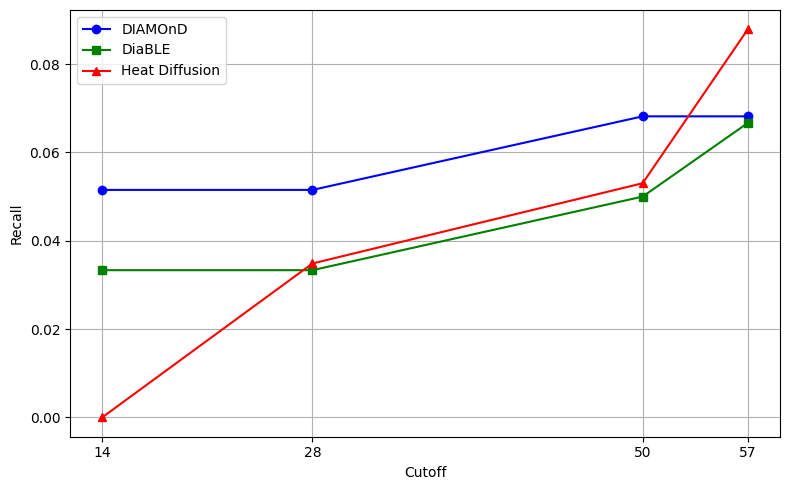

In [ ]:
# Recall scores for each method at each cutoff
diamond_f1 = [diamond_results[14]['recall_mean'],diamond_results[28]['recall_mean'],diamond_results[50]['recall_mean'],diamond_results[57]['recall_mean']]
diable_f1  = [diable_results[14]['recall_mean'],diable_results[28]['recall_mean'],diable_results[50]['recall_mean'],diable_results[57]['recall_mean']]
heat_f1    = [diffusion_results[14]['recall_mean'],diffusion_results[28]['recall_mean'],diffusion_results[50]['recall_mean'],diffusion_results[57]['recall_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(cutoffs, diamond_f1, marker='o', label='DIAMOnD', color='blue')
plt.plot(cutoffs, diable_f1, marker='s', label='DiaBLE', color='green')
plt.plot(cutoffs, heat_f1, marker='^', label='Heat Diffusion', color='red')

# Labels and title
plt.xticks(cutoffs)
plt.xlabel('Cutoff')
plt.ylabel('Recall')
# plt.title('Recall vs. Cutoff for DIAMOnD, DiaBLE, and Heat Diffusion')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

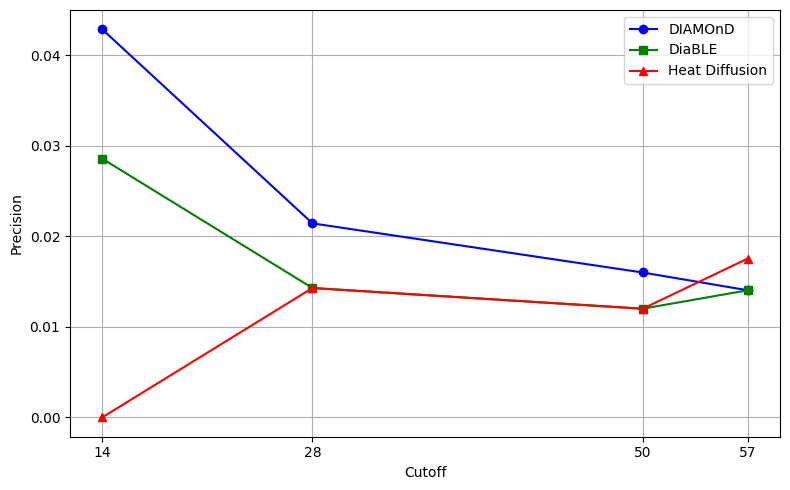

In [ ]:
# Precision scores for each method at each cutoff
diamond_f1 = [diamond_results[14]['precision_mean'],diamond_results[28]['precision_mean'],diamond_results[50]['precision_mean'],diamond_results[57]['precision_mean']]
diable_f1  = [diable_results[14]['precision_mean'],diable_results[28]['precision_mean'],diable_results[50]['precision_mean'],diable_results[57]['precision_mean']]
heat_f1    = [diffusion_results[14]['precision_mean'],diffusion_results[28]['precision_mean'],diffusion_results[50]['precision_mean'],diffusion_results[57]['precision_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(cutoffs, diamond_f1, marker='o', label='DIAMOnD', color='blue')
plt.plot(cutoffs, diable_f1, marker='s', label='DiaBLE', color='green')
plt.plot(cutoffs, heat_f1, marker='^', label='Heat Diffusion', color='red')

# Labels and title
plt.xticks(cutoffs)
plt.xlabel('Cutoff')
plt.ylabel('Precision')
# plt.title('Precision vs. Cutoff for DIAMOnD, DiaBLE, and Heat Diffusion')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

# PUNTO 3!

## 3.1

In [ ]:
 outfile_name = "/content/drive/My Drive/BIOINFORMATICS/diamond_2.tsv"
 top_predicted=DIAMOnD.DIAMOnD(G, list(cmt_data_cor['Gene ID'].unique()), max_number_of_added_nodes=200, alpha = 1, outfile=outfile_name)

DIAMOnD(): ignoring 8 of 87 seed genes that are not in the network


In [ ]:
# Load DIAMOnD results
diamond_results_2 = pd.read_csv("/content/drive/My Drive/BIOINFORMATICS/diamond_2.tsv", sep="\t")

# Display the first few rows
print(diamond_results_2.head(10))

   #rank DIAMOnD_node       p_hyper
0      1       TRIM67  2.032397e-11
1      2       SEC16A  1.123899e-10
2      3       OCIAD1  1.070462e-09
3      4        DERL1  3.592533e-10
4      5         CAV1  4.700127e-10
5      6        PTPN1  4.587236e-10
6      7        RAB35  1.708888e-10
7      8      ALDH3A2  4.304258e-11
8      9         RHOA  1.539269e-11
9     10        AKAP1  4.978322e-12


In [ ]:
pdg=diamond_results_2['DIAMOnD_node'].iloc[:100]

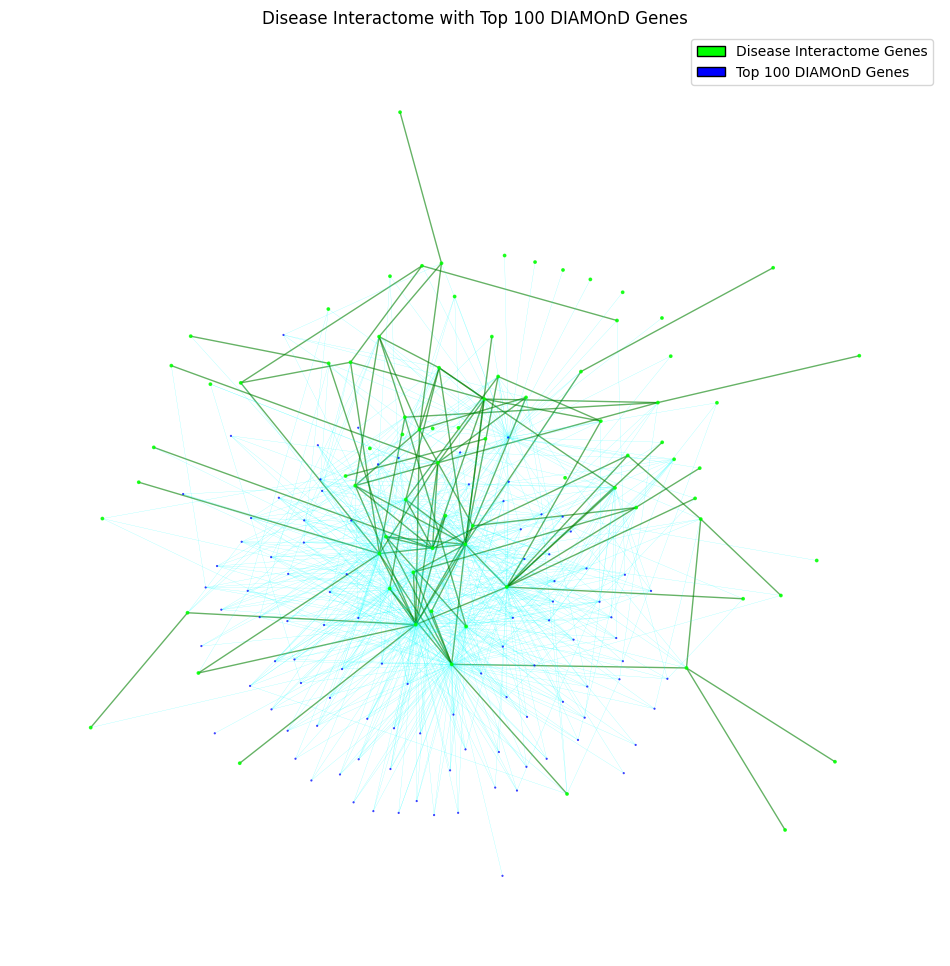

In [ ]:
final_graph = nx.Graph()
final_graph.add_nodes_from(disease_interactome.nodes(data=True))
final_graph.add_edges_from(disease_interactome.edges(data=True))

pdg2 = set(pdg)
for gene in pdg2:
    if gene in G:
        final_graph.add_node(gene)
        for neighbor in G.neighbors(gene):
                if neighbor in disease_interactome:
                  final_graph.add_edge(gene, neighbor)


node_colors = {}
color_map = {
    'pdg': 'blue',
    'Disease': 'lime',
}

node_sizes = []
for node in final_graph.nodes():
    if node in pdg2:
        node_colors[node] = color_map['pdg']
        node_sizes.append(0.3)
    else:
        node_colors[node] = color_map['Disease']
        node_sizes.append(3)

edge_colors = []
edge_widths = []
disease_nodes = set(disease_interactome.nodes())

for u, v in final_graph.edges():
    if u in disease_nodes and v in disease_nodes:
        edge_colors.append('green')
        edge_widths.append(1)
    else:
        edge_colors.append('cyan')
        edge_widths.append(0.15)


plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(final_graph, weight=None)
nx.draw_networkx_nodes(final_graph, pos,
                       node_color=[node_colors[node] for node in final_graph.nodes()],
                       node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(final_graph, pos,
                       edge_color=edge_colors,width=edge_widths, alpha=0.6)


legend_elements = [
    Patch(facecolor=color_map['Disease'], edgecolor='k', label='Disease Interactome Genes'),
    Patch(facecolor=color_map['pdg'], edgecolor='k', label='Top 100 DIAMOnD Genes'),

]
plt.legend(handles=legend_elements, loc='best', fontsize='medium')

plt.title("Disease Interactome with Top 100 DIAMOnD Genes")
plt.axis('off')
plt.show()


### 3.2 ENRICHMENT ANALYSIS

#### 3.2.1

In [ ]:
def enrichment_analysis(genes, gene_set_library):
    enrichr_results = gp.enrichr(
        gene_list=genes,
        gene_sets=gene_set_library,
        organism="Human",
        outdir=None,
        cutoff=0.05)

    results_df = enrichr_results.results
    if results_df is None or results_df.empty:
        return pd.DataFrame()  # return empty DataFrame if nothing found

    # Filter for significant terms
    return results_df[results_df["Adjusted P-value"] < 0.05]

In [ ]:
def enrichment_analysis(genes, gene_set_library, max_retries=3):
    for attempt in range(max_retries):
        try:
            enrichr_results = gp.enrichr(
                gene_list=genes,
                gene_sets=gene_set_library,
                organism="Human",
                outdir=None,
                cutoff=0.05,
            )
            df = enrichr_results.results
            if df is not None and not df.empty:
                return df[df["Adjusted P-value"] < 0.05]
            else:
                return pd.DataFrame()
        except Exception as e:
            print(f"Attempt {attempt + 1} failed for {gene_set_library}: {e}")
            time.sleep(2 * (attempt + 1))  # wait and retry
    print(f"Failed to fetch results for {gene_set_library} after {max_retries} attempts.")
    return pd.DataFrame()

In [ ]:

# we perform enrichment analysis the libraries
enrichr_libraries = [
    "GO_Biological_Process_2021",
    "GO_Molecular_Function_2021",
    "GO_Cellular_Component_2021",
    "Reactome_2022",
    "KEGG_2021_Human",
]

genes_of_interest = list(pdg)  # convert to list if not already

putative_results = {}
for library in enrichr_libraries:
    print(f"\n Enrichment analysis for {library}:")
    result = enrichment_analysis(genes_of_interest, library)
    putative_results[library] = result
    print(f"Results for {library} (Putative Genes):")
    if not result.empty:
        print(result[["Term", "Overlap", "Adjusted P-value"]].head())
    else:
        print("No significant enrichment found.")
    print(f"----------------------------------")



 Enrichment analysis for GO_Biological_Process_2021:
Results for GO_Biological_Process_2021 (Putative Genes):
                                                Term Overlap  Adjusted P-value
0    endoplasmic reticulum organization (GO:0007029)   11/73      7.074284e-11
1  protein import into peroxisome membrane (GO:00...    7/22      4.685121e-09
2         protein targeting to membrane (GO:0006612)   10/87      5.533994e-09
3                organelle organization (GO:0006996)  17/420      6.803092e-09
4        peroxisomal membrane transport (GO:0015919)    7/27      9.561704e-09
----------------------------------

 Enrichment analysis for GO_Molecular_Function_2021:
Results for GO_Molecular_Function_2021 (Putative Genes):
                                                Term Overlap  Adjusted P-value
0  dolichyl-diphosphooligosaccharide-protein glyc...     3/5          0.000169
1   oligosaccharyl transferase activity (GO:0004576)     3/6          0.000169
2         guanyl ribonucleotide 

<ipython-input-44-0effddb239d7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=-top_df["Combined Score"], y=top_df["Term"], palette="viridis")


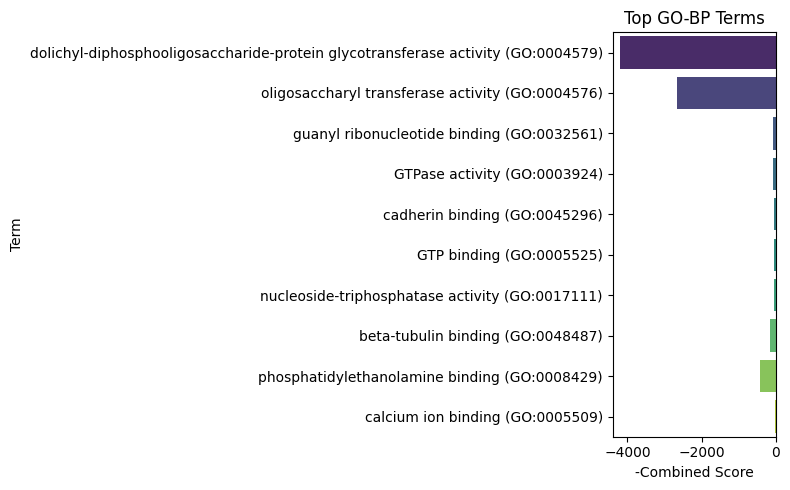

In [ ]:
def plot_top_terms(df, title, top_n=10):
    if df.empty:
        print(f"No data to plot for {title}")
        return
    top_df = df.nsmallest(top_n, "Adjusted P-value")
    plt.figure(figsize=(8, 5))
    sns.barplot(x=-top_df["Combined Score"], y=top_df["Term"], palette="viridis")
    plt.title(title)
    plt.xlabel("-Combined Score")
    plt.tight_layout()
    plt.show()

plot_top_terms(putative_results["GO_Molecular_Function_2021"], "Top GO-BP Terms")


#### 3.2.2

In [ ]:
original_results = {}
genes_of_interest = list(cmt_data_cor['Gene ID'].unique())
for library in enrichr_libraries:
    print(f"\n Enrichment analysis for {library}:")
    result = enrichment_analysis(genes_of_interest, library)
    original_results[library] = result
    print(f"Results for {library} (Putative Genes):")
    if not result.empty:
        print(result[["Term", "Overlap", "Adjusted P-value"]].head())
    else:
        print("No significant enrichment found.")
    print(f"----------------------------------")


 Enrichment analysis for GO_Biological_Process_2021:
Results for GO_Biological_Process_2021 (Putative Genes):
                                                Term Overlap  Adjusted P-value
0                   tRNA aminoacylation (GO:0043039)    7/38      2.478987e-07
1  tRNA aminoacylation for protein translation (G...    7/43      3.109940e-07
2          response to unfolded protein (GO:0006986)    5/49      7.208937e-04
3                           translation (GO:0006412)   8/214      7.748963e-04
4  antigen processing and presentation of exogeno...    6/98      7.748963e-04
----------------------------------

 Enrichment analysis for GO_Molecular_Function_2021:
Results for GO_Molecular_Function_2021 (Putative Genes):
                                                Term Overlap  Adjusted P-value
0        aminoacyl-tRNA ligase activity (GO:0004812)    7/38      4.587820e-08
1                           ATP binding (GO:0005524)   9/278      2.881934e-04
2  purine ribonucleoside triphos

<ipython-input-46-9d63d76a8511>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=-top_df["Combined Score"], y=top_df["Term"], palette="viridis")


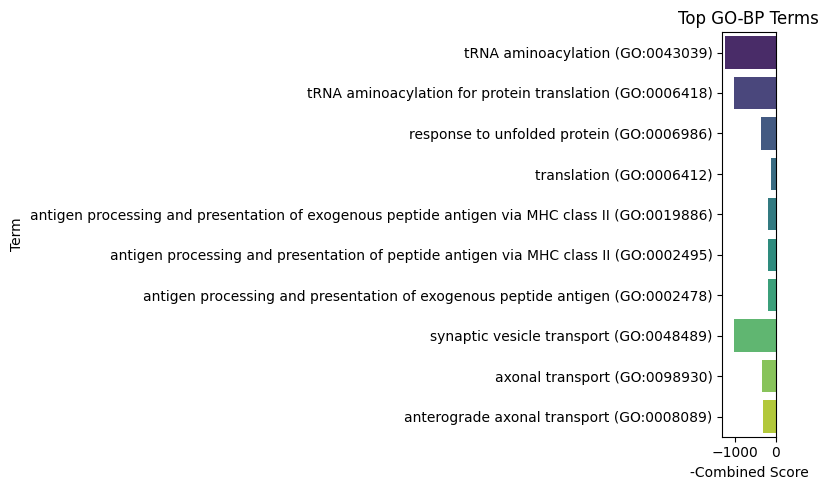

In [ ]:
def plot_top_terms(df, title, top_n=10):
    if df.empty:
        print(f"No data to plot for {title}")
        return
    top_df = df.nsmallest(top_n, "Adjusted P-value")
    plt.figure(figsize=(8, 5))
    sns.barplot(x=-top_df["Combined Score"], y=top_df["Term"], palette="viridis")
    plt.title(title)
    plt.xlabel("-Combined Score")
    plt.tight_layout()
    plt.show()

plot_top_terms(original_results["GO_Biological_Process_2021"], "Top GO-BP Terms")


#### 3.2.3

In [ ]:
def get_significant_terms(results_dict):
    term_dict = {}
    for lib, df in results_dict.items():
        if not df.empty:
            terms = set(df["Term"].str.lower().str.strip())
            term_dict[lib] = terms
        else:
            term_dict[lib] = set()
    return term_dict

# Extract sets of enriched terms
original_terms = get_significant_terms(original_results)
putative_terms = get_significant_terms(putative_results)

# Compare overlap between original and putative enriched terms
print("\n Overlap of enriched terms between original and putative gene sets:\n")

overlap_summary = {}
for lib in enrichr_libraries:
    overlap = original_terms[lib] & putative_terms[lib]
    overlap_summary[lib] = overlap
    print(f"{lib}:")
    print(f" - Original terms: {len(original_terms[lib])}")
    print(f" - Putative terms: {len(putative_terms[lib])}")
    print(f" - Overlapping terms: {len(overlap)}")
    if overlap:
        print("   ➤ Examples:", list(overlap)[:5])
    else:
        print("   ➤ No overlap found.")
    print("-" * 40)



 Overlap of enriched terms between original and putative gene sets:

GO_Biological_Process_2021:
 - Original terms: 49
 - Putative terms: 87
 - Overlapping terms: 4
   ➤ Examples: ['mitochondrion organization (go:0007005)', 'protein targeting to mitochondrion (go:0006626)', 'response to unfolded protein (go:0006986)', 'establishment of protein localization to mitochondrion (go:0072655)']
----------------------------------------
GO_Molecular_Function_2021:
 - Original terms: 17
 - Putative terms: 13
 - Overlapping terms: 1
   ➤ Examples: ['nucleoside-triphosphatase activity (go:0017111)']
----------------------------------------
GO_Cellular_Component_2021:
 - Original terms: 6
 - Putative terms: 30
 - Overlapping terms: 2
   ➤ Examples: ['endoplasmic reticulum membrane (go:0005789)', 'lipid droplet (go:0005811)']
----------------------------------------
Reactome_2022:
 - Original terms: 27
 - Putative terms: 44
 - Overlapping terms: 4
   ➤ Examples: ['rho gtpase cycle r-hsa-9012999', '

In [ ]:
for category, terms in overlap_summary.items():
    print(f"\n=== {category} ===")
    if terms:
        for term in sorted(terms):
            print(f" - {term}")
    else:
        print("No overlap found")



=== GO_Biological_Process_2021 ===
 - establishment of protein localization to mitochondrion (go:0072655)
 - mitochondrion organization (go:0007005)
 - protein targeting to mitochondrion (go:0006626)
 - response to unfolded protein (go:0006986)

=== GO_Molecular_Function_2021 ===
 - nucleoside-triphosphatase activity (go:0017111)

=== GO_Cellular_Component_2021 ===
 - endoplasmic reticulum membrane (go:0005789)
 - lipid droplet (go:0005811)

=== Reactome_2022 ===
 - rho gtpase cycle r-hsa-9012999
 - selective autophagy r-hsa-9663891
 - signaling by rho gtpases r-hsa-194315
 - signaling by rho gtpases, miro gtpases and rhobtb3 r-hsa-9716542

=== KEGG_2021_Human ===
 - amyotrophic lateral sclerosis
 - pathways of neurodegeneration


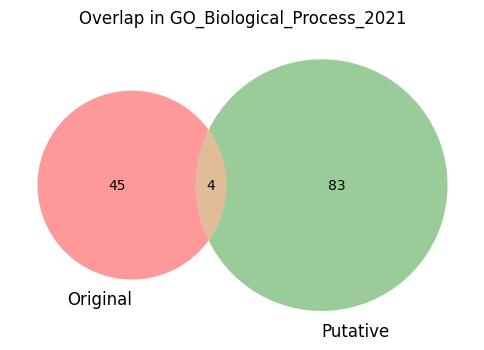

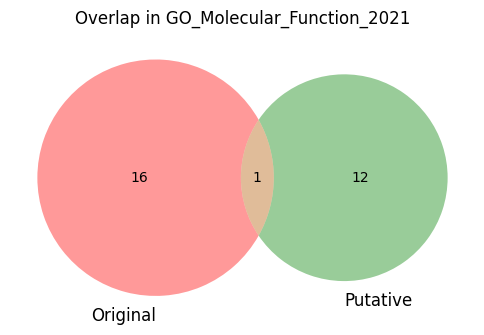

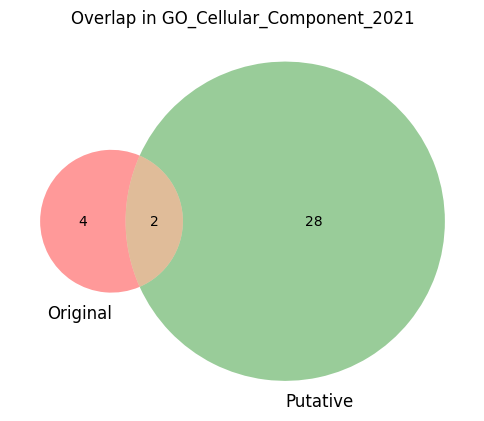

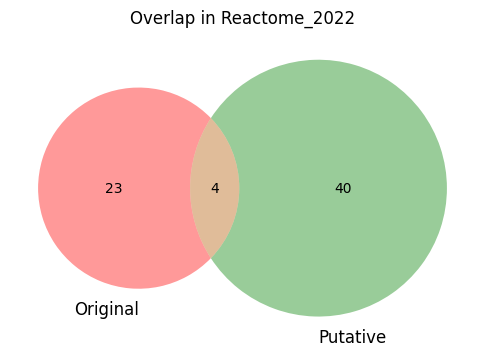

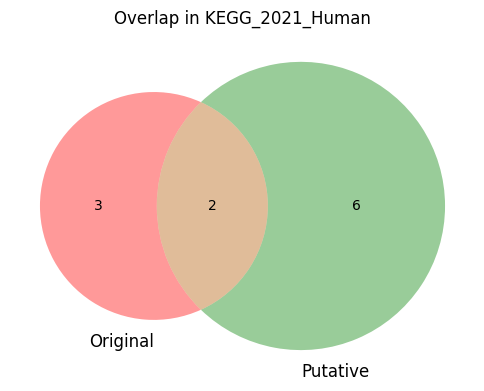

In [ ]:
def plot_overlap(lib):
    terms1 = original_terms[lib]
    terms2 = putative_terms[lib]

    plt.figure(figsize=(6, 6))
    venn2([terms1, terms2], set_labels=('Original', 'Putative'))
    plt.title(f"Overlap in {lib}")
    plt.show()

plot_overlap("GO_Biological_Process_2021")
plot_overlap("GO_Molecular_Function_2021")
plot_overlap("GO_Cellular_Component_2021")
plot_overlap("Reactome_2022")
plot_overlap("KEGG_2021_Human")


# PUNTO 4!

## Drug identification

4.1.1

In [ ]:
# Collect putative genes associated with overlapping terms
putative_genes_in_overlap = defaultdict(set)

for lib in enrichr_libraries:
    overlapping_terms = overlap_summary[lib]
    if not overlapping_terms:
        continue

    # Get the putative results dataframe
    df = putative_results[lib]
    if df.empty:
        continue

    for _, row in df.iterrows():
        term = row["Term"].lower().strip()
        if term in overlapping_terms:
            # Check if there's a 'Genes' column (preferred)
            if "Genes" in row:
                genes = row["Genes"].split(";")
            elif "Genes Matched" in row:
                genes = row["Genes Matched"].split(";")
            else:
                # Fallback to parsing from 'Overlap' if nothing else is available
                genes = row["Overlap"].split("/")[0].split(",")
            putative_genes_in_overlap[lib].update(g.strip() for g in genes)

all_overlap_genes = set()
for lib_genes in putative_genes_in_overlap.values():
    all_overlap_genes.update(lib_genes)

print("Putative genes involved in overlapping enriched terms:")
print(all_overlap_genes)
print(f"Total unique genes: {len(all_overlap_genes)}")

Putative genes involved in overlapping enriched terms:
{'CANX', 'FAF2', 'TEX2', 'FIS1', 'BCAP31', 'TOMM20', 'EIF2AK3', 'SEC61B', 'ATP2A1', 'WDR41', 'B3GAT1', 'CAV1', 'RAB3B', 'DNAJC25', 'ABCD3', 'RABL3', 'LSG1', 'HSD17B11', 'RHOT2', 'TMPO', 'PTPN1', 'EMD', 'SCFD1', 'UBE2J1', 'SSR1', 'ANKLE2', 'RPN1', 'SMCR8', 'CDKAL1', 'TOMM22', 'TEX264', 'PGRMC2', 'RPN2', 'HSD3B7', 'SEC16A', 'VAPB', 'VRK2', 'ACBD5', 'PDZD8', 'USP30', 'RHOA', 'ALDH3A2', 'RAB35', 'METTL7A', 'DERL1', 'STT3B', 'VPS13D', 'ACSL3', 'CKAP4', 'STIM1', 'NUP155', 'RAB5A', 'ESYT1', 'ESYT2', 'TOR1AIP1', 'LMAN1', 'VAPA', 'STBD1', 'SMPD4', 'AUP1', 'ELOVL5', 'YKT6'}
Total unique genes: 62


In [ ]:
filtered_diamond_results = diamond_results_2[
    diamond_results_2['DIAMOnD_node'].isin(all_overlap_genes)
]

print(f"Filtered DIAMOnD results: {filtered_diamond_results.shape[0]} genes retained")
filtered_diamond_results.head()

Filtered DIAMOnD results: 62 genes retained


#rank DIAMOnD_node       p_hyper
1      2       SEC16A  1.123899e-10
3      4        DERL1  3.592533e-10
4      5         CAV1  4.700127e-10
5      6        PTPN1  4.587236e-10
6      7        RAB35  1.708888e-10

In [ ]:
top20_putative_genes = filtered_diamond_results.head(20)["DIAMOnD_node"].tolist()

In [ ]:
top20_putative_genes

['SEC16A',
 'DERL1',
 'CAV1',
 'PTPN1',
 'RAB35',
 'ALDH3A2',
 'RHOA',
 'VPS13D',
 'SMCR8',
 'WDR41',
 'RAB3B',
 'RHOT2',
 'FIS1',
 'YKT6',
 'ACBD5',
 'ABCD3',
 'TOMM22',
 'FAF2',
 'LMAN1',
 'STIM1']

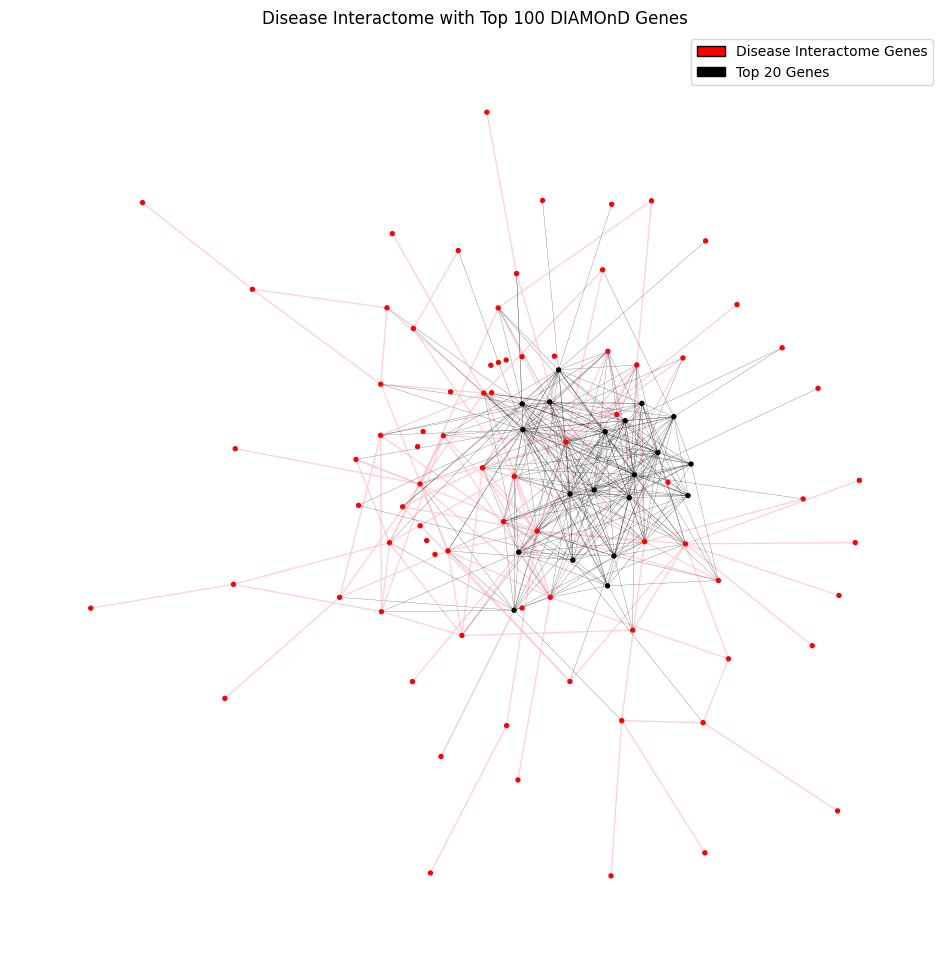

In [ ]:
final_graph = nx.Graph()
final_graph.add_nodes_from(disease_interactome.nodes(data=True))
final_graph.add_edges_from(disease_interactome.edges(data=True))


top20 = set(top20_putative_genes)
for gene in top20:
    if gene in G:
        final_graph.add_node(gene)
        for neighbor in G.neighbors(gene):
            if neighbor in final_graph:
                final_graph.add_edge(gene, neighbor)


node_colors = {}
color_map = {
    'top20': 'black',
    'Disease': 'red',
}

for node in final_graph.nodes():
    if node in top20:
        node_colors[node] = color_map['top20']
    else:
        node_colors[node] = color_map['Disease']

edge_colors = []
edge_widths = []
disease_nodes = set(disease_interactome.nodes())

for u, v in final_graph.edges():
    if u in disease_nodes and v in disease_nodes:
        edge_colors.append('pink')
        edge_widths.append(1)
    else:
        edge_colors.append('black')
        edge_widths.append(0.2)


plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(final_graph, weight=None)
nx.draw_networkx_nodes(final_graph, pos,
                       node_color=[node_colors[node] for node in final_graph.nodes()],
                       node_size=8, alpha=1)
nx.draw_networkx_edges(final_graph, pos,
                       edge_color=edge_colors,width=edge_widths, alpha=0.7)


legend_elements = [
    Patch(facecolor=color_map['Disease'], edgecolor='k', label='Disease Interactome Genes'),
    Patch(facecolor=color_map['top20'], edgecolor='k', label='Top 20 Genes'),
  #  Patch(facecolor='gray', edgecolor='k', label='Disease-Disease Edge'),
   # Patch(facecolor='black', edgecolor='k', label='Other Edge'),
]
plt.legend(handles=legend_elements, loc='best', fontsize='medium')

plt.title("Disease Interactome with Top 100 DIAMOnD Genes")
plt.axis('off')
plt.show()


#### 4.1.2

In [ ]:
interactions_df = pd.read_csv("/content/drive/My Drive/BIOINFORMATICS/interactions.tsv", sep="\t", low_memory=False)

# Step 2: Filter for approved drugs
approved_interactions = interactions_df[interactions_df["approved"] == True]

# Step 3: Keep only interactions with the top 20 genes
filtered_interactions = approved_interactions[
    approved_interactions["gene_name"].isin(top20_putative_genes)
]

# Step 4: Count how many of the top 20 genes each drug targets
drug_gene_info = (
    filtered_interactions.groupby("drug_name")["gene_name"]
    .agg(["nunique", lambda genes: ", ".join(sorted(set(genes)))])
    .reset_index()
    .rename(columns={"nunique": "num_targeted_genes", "<lambda_0>": "target_genes"})
    .sort_values(by="num_targeted_genes", ascending=False)
)

# Step 4: Display the final result
print("Ranked list of approved drugs with associated top-20 genes:")
print(drug_gene_info.head(1000))

Ranked list of approved drugs with associated top-20 genes:
                 drug_name  num_targeted_genes target_genes
0             CAPECITABINE                   1       VPS13D
1       DEHYDRATED ALCOHOL                   1         CAV1
2               DISULFIRAM                   1      ALDH3A2
3  INSULIN, REGULAR, HUMAN                   1        PTPN1
4       PRAVASTATIN SODIUM                   1         RHOA
5                QUINIDINE                   1         RHOA
6              SIMVASTATIN                   1         RHOA
7             TESTOSTERONE                   1         CAV1
8          TILUDRONIC ACID                   1        PTPN1
9              VINCRISTINE                   1        STIM1


In [ ]:
interactions_df = pd.read_csv("/content/drive/My Drive/BIOINFORMATICS/interactions.tsv", sep="\t", low_memory=False)


approved_interactions = interactions_df[interactions_df["approved"] == True]


filtered_interactions = approved_interactions[
    approved_interactions["gene_name"].isin(diamond_results.head(20)["DIAMOnD_node"].tolist())
]

# Count how many of the top 20 genes each drug targets
drug_gene_info = (
    filtered_interactions.groupby("drug_name")["gene_name"]
    .agg(["nunique", lambda genes: ", ".join(sorted(set(genes)))])
    .reset_index()
    .rename(columns={"nunique": "num_targeted_genes", "<lambda_0>": "target_genes"})
    .sort_values(by="num_targeted_genes", ascending=False)
)


print("Ranked list of approved drugs with associated top-20 genes:")
print(drug_gene_info.head(1000))

Ranked list of approved drugs with associated top-20 genes:
                 drug_name  num_targeted_genes target_genes
0             CAPECITABINE                   1       VPS13D
1       DEHYDRATED ALCOHOL                   1         CAV1
2               DISULFIRAM                   1      ALDH3A2
3  INSULIN, REGULAR, HUMAN                   1        PTPN1
4       PRAVASTATIN SODIUM                   1         RHOA
5                QUINIDINE                   1         RHOA
6              SIMVASTATIN                   1         RHOA
7             TESTOSTERONE                   1         CAV1
8          TILUDRONIC ACID                   1        PTPN1


https://clinicaltrials.gov/search?cond=Charcot-Marie-Tooth%20Disease&term=Insulin

# PUNTO 5!

In [ ]:
#**********************************************#
#       PUT PROCONSUL.py IN CONTENTS           #
#**********************************************#

In [ ]:
import proconsul

In [ ]:
node_ranks=proconsul.PROCONSUL(G,seed_genes,max_number_of_added_nodes=200,
                    alpha=1,outfile="/content/drive/My Drive/BIOINFORMATICS/proconsul.tsv")

PROCONSUL(): Round 1/10
PROCONSUL(): Round 2/10
PROCONSUL(): Round 3/10
PROCONSUL(): Round 4/10
PROCONSUL(): Round 5/10
PROCONSUL(): Round 6/10
PROCONSUL(): Round 7/10
PROCONSUL(): Round 8/10
PROCONSUL(): Round 9/10
PROCONSUL(): Round 10/10


In [ ]:
node_ranks=pd.read_csv("/content/drive/My Drive/BIOINFORMATICS/proconsul.tsv", sep="\t", low_memory=False)


In [ ]:
node_ranks['node'].iloc[0:20]

0      OCIAD1
1      VPS13D
2        EXD2
3      MARCH5
4       PTPN1
5       TDRKH
6       FKBP8
7     ALDH3A2
8       AKAP1
9       RHOT2
10      MTCH1
11       FIS1
12      USP30
13      MTFR1
14       MAVS
15      UBXN4
16     TOMM22
17       MTX2
18      PEX14
19      SMCR8
Name: node, dtype: object

In [ ]:
ranked_genes =node_ranks['node'].iloc[0:20]  # Descending


overlap = set(top20_putative_genes) & set(ranked_genes)
print("\nTop 20 Predicted Genes:")
print(ranked_genes)

print("\nOverlap with known top-20 putative genes:")
print(overlap)
print(f"\nNumber of overlapping genes: {len(overlap)}")


Top 20 Predicted Genes:
0      OCIAD1
1      VPS13D
2        EXD2
3      MARCH5
4       PTPN1
5       TDRKH
6       FKBP8
7     ALDH3A2
8       AKAP1
9       RHOT2
10      MTCH1
11       FIS1
12      USP30
13      MTFR1
14       MAVS
15      UBXN4
16     TOMM22
17       MTX2
18      PEX14
19      SMCR8
Name: node, dtype: object

Overlap with known top-20 putative genes:
{'MTCH1', 'FKBP8', 'RHOT2', 'EXD2', 'MTFR1', 'MARCH5', 'PTPN1', 'SMCR8', 'VPS13D', 'AKAP1', 'MAVS', 'TDRKH', 'OCIAD1', 'FIS1', 'TOMM22', 'MTX2', 'USP30', 'UBXN4'}

Number of overlapping genes: 18


In [ ]:
set(ranked_genes)-set(top20_putative_genes)

{'ALDH3A2', 'PEX14'}